In [10]:
#downloading and interfacing with Etsy API
import requests
import json 
from dotenv import dotenv_values

from ediblepickle import checkpoint
from urllib.parse import quote
from retrying import retry

import os
import glob
import time

#data preprocessing
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer

import re

#exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#exploratory image visualization
import matplotlib.image as mpimg

In [11]:
#Read private API key 
#Note: for deployment, this is dealt with Heroku's config vars
config = dotenv_values('.env')
etsy_key = config['x-api-key']


In [12]:
headers = { 'x-api-key' : etsy_key }

# Part I: Download basic listing data (price, dimensions, materials, etc.) for all paintings for sale within a certain price range. 

## Preparatory Steps

### Get the full hierarchy tree of seller taxonomy nodes, to find the one I am interested in (paintings)

In [13]:
url_taxonomy = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes'

In [14]:
response_taxonomy = requests.get(url_taxonomy, headers = headers)

In [15]:
response_taxonomy

<Response [200]>

In [16]:
response_taxonomy.reason

'OK'

In [17]:
response_taxonomy_data = response_taxonomy.json() 

In [18]:
response_taxonomy_data.keys()

dict_keys(['count', 'results'])

In [19]:
#results is a list of nested dictionaries
len(response_taxonomy_data['results'])

15

In [20]:
#lets's start with the main tree to see the 15 main categories and find where painting may be
[(main_category['name'], counter) for counter, main_category in enumerate(response_taxonomy_data['results'])]

[('Accessories', 0),
 ('Art & Collectibles', 1),
 ('Bags & Purses', 2),
 ('Bath & Beauty', 3),
 ('Books, Movies & Music', 4),
 ('Clothing', 5),
 ('Craft Supplies & Tools', 6),
 ('Electronics & Accessories', 7),
 ('Home & Living', 8),
 ('Jewelry', 9),
 ('Paper & Party Supplies', 10),
 ('Pet Supplies', 11),
 ('Shoes', 12),
 ('Toys & Games', 13),
 ('Weddings', 14)]

In [21]:
#Let's dive into Art and Collectibles
[(art_category['name'], counter) for counter, art_category in enumerate(response_taxonomy_data['results'][1]['children'])]
#response_taxonomy_data['results'][1]['children']

[('Collectibles', 0),
 ('Drawing & Illustration', 1),
 ('Fiber Arts', 2),
 ('Mixed Media & Collage', 3),
 ('Glass Art', 4),
 ('Painting', 5),
 ('Photography', 6),
 ('Prints', 7),
 ('Sculpture', 8),
 ('Dolls & Miniatures', 9),
 ('Artist Trading Cards', 10),
 ('Fine Art Ceramics', 11)]

In [22]:
#Let's look at painting
response_taxonomy_data['results'][1]['children'][5]

{'id': 105,
 'level': 2,
 'name': 'Painting',
 'parent_id': 66,
 'children': [{'id': 106,
   'level': 3,
   'name': 'Acrylic',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 106]},
  {'id': 107,
   'level': 3,
   'name': 'Combination',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 107]},
  {'id': 108,
   'level': 3,
   'name': 'Encaustics',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 108]},
  {'id': 109,
   'level': 3,
   'name': 'Gouache',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 109]},
  {'id': 110,
   'level': 3,
   'name': 'Ink',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 110]},
  {'id': 111,
   'level': 3,
   'name': 'Mixed',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 111]},
  {'id': 112,
   'level': 3,
   'name': 'Oil',
   'parent_id': 105,
   'children': [],
   'full_path_

In [23]:
#Paintings are themselves divided into different groups based on materials, and there are no more children, so I can now collect the taxonomy id's and the full path taxonomy id's just in case
paintings_taxonomy_list = [(painting_category['name'], painting_category['id'], painting_category['full_path_taxonomy_ids']) for painting_category in response_taxonomy_data['results'][1]['children'][5]['children']]
paintings_taxonomy_list

[('Acrylic', 106, [66, 105, 106]),
 ('Combination', 107, [66, 105, 107]),
 ('Encaustics', 108, [66, 105, 108]),
 ('Gouache', 109, [66, 105, 109]),
 ('Ink', 110, [66, 105, 110]),
 ('Mixed', 111, [66, 105, 111]),
 ('Oil', 112, [66, 105, 112]),
 ('Spray Paint', 113, [66, 105, 113]),
 ('Watercolor', 114, [66, 105, 114])]

### Paintings taxonomy

In [24]:
paintings_taxonomy_df = pd.DataFrame(paintings_taxonomy_list, columns = ['Material','Taxonomy Id','Full path Id'])

In [25]:
paintings_taxonomy_df

,Material,Taxonomy Id,Full path Id
0,Acrylic,106,"[66, 105, 106]"
1,Combination,107,"[66, 105, 107]"
2,Encaustics,108,"[66, 105, 108]"
3,Gouache,109,"[66, 105, 109]"
4,Ink,110,"[66, 105, 110]"
5,Mixed,111,"[66, 105, 111]"
6,Oil,112,"[66, 105, 112]"
7,Spray Paint,113,"[66, 105, 113]"
8,Watercolor,114,"[66, 105, 114]"


In [26]:
#I am also adding the number of available paintings in the two price ranges of interest ($100<price<$250, $250<=price<=$750), which I manually checked (as of 10/15):
paintings_taxonomy_df['num_listings_100to250USD']=[130096, 8126, 1121, 2885, 4019, 10920, 107000, 1177, 54127] 
paintings_taxonomy_df['num_listings_250to750USD']=[92172, 5068, 721, 1299, 1371, 8026, 97396, 422, 19796]

In [27]:
paintings_taxonomy_df

,Material,Taxonomy Id,Full path Id,num_listings_100to250USD,num_listings_250to750USD
0,Acrylic,106,"[66, 105, 106]",130096,92172
1,Combination,107,"[66, 105, 107]",8126,5068
2,Encaustics,108,"[66, 105, 108]",1121,721
3,Gouache,109,"[66, 105, 109]",2885,1299
4,Ink,110,"[66, 105, 110]",4019,1371
5,Mixed,111,"[66, 105, 111]",10920,8026
6,Oil,112,"[66, 105, 112]",107000,97396
7,Spray Paint,113,"[66, 105, 113]",1177,422
8,Watercolor,114,"[66, 105, 114]",54127,19796


In [28]:
paintings_taxonomy_df['num_listings_250to750USD'].sum()

226271

In [29]:
paintings_taxonomy_df.set_index('Taxonomy Id')


,Material,Full path Id,num_listings_100to250USD,num_listings_250to750USD
Taxonomy Id,,,,
106,Acrylic,"[66, 105, 106]",130096,92172
107,Combination,"[66, 105, 107]",8126,5068
108,Encaustics,"[66, 105, 108]",1121,721
109,Gouache,"[66, 105, 109]",2885,1299
110,Ink,"[66, 105, 110]",4019,1371
111,Mixed,"[66, 105, 111]",10920,8026
112,Oil,"[66, 105, 112]",107000,97396
113,Spray Paint,"[66, 105, 113]",1177,422
114,Watercolor,"[66, 105, 114]",54127,19796


In [30]:
paintings_taxonomy_df.set_index('Taxonomy Id').loc[106]

Material                           Acrylic
Full path Id                [66, 105, 106]
num_listings_100to250USD            130096
num_listings_250to750USD             92172
Name: 106, dtype: object

In [31]:
#Now let's request the properties given for each listing in these categories, with a separate request
url_properties_acrylic = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/106/properties'
response_properties_acrylic = requests.get(url_properties_acrylic, headers = headers)
response_properties_acrylic_data = response_properties_acrylic.json() 

In [32]:
response_properties_acrylic_data.keys()

dict_keys(['count', 'results'])

In [33]:
paintings_property_list_acrylic = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_acrylic_data['results']]
paintings_property_list_acrylic

[(200, 'Primary color'),
 (52047899002, 'Secondary color'),
 (400394338806, 'Art subject'),
 (570246213481, 'Art style'),
 (145330288652, 'Home style'),
 (570246213482, 'Surface material'),
 (406291158455, 'Orientation'),
 (145330288558, 'Framing'),
 (47626759834, 'Height'),
 (47626759898, 'Width'),
 (54142602037, 'Depth'),
 (145330288592, 'Room'),
 (46803063659, 'Holiday'),
 (46803063641, 'Occasion'),
 (504, 'Diameter'),
 (501, 'Dimensions'),
 (502, 'Fabric'),
 (500, 'Finish'),
 (503, 'Flavor'),
 (506, 'Length'),
 (507, 'Material'),
 (508, 'Pattern'),
 (509, 'Scent'),
 (100, 'TeeShirtSize'),
 (510, 'Style'),
 (511, 'Weight'),
 (515, 'Device'),
 (513, 'Custom1'),
 (514, 'Custom2')]

In [34]:
#Let's check that the same properties and code apply to the other paintings' types, e.g. spray paint:

url_properties_spraypaint = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/113/properties'
response_properties_spraypaint = requests.get(url_properties_spraypaint, headers = headers)
response_properties_spraypaint_data = response_properties_spraypaint.json() 


In [35]:
paintings_property_list_spraypaint = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_spraypaint_data['results']]
paintings_property_list_spraypaint

[(200, 'Primary color'),
 (52047899002, 'Secondary color'),
 (400394338806, 'Art subject'),
 (570246213481, 'Art style'),
 (145330288652, 'Home style'),
 (570246213482, 'Surface material'),
 (406291158455, 'Orientation'),
 (145330288558, 'Framing'),
 (47626759834, 'Height'),
 (47626759898, 'Width'),
 (54142602037, 'Depth'),
 (145330288592, 'Room'),
 (46803063659, 'Holiday'),
 (46803063641, 'Occasion'),
 (504, 'Diameter'),
 (501, 'Dimensions'),
 (502, 'Fabric'),
 (500, 'Finish'),
 (503, 'Flavor'),
 (506, 'Length'),
 (507, 'Material'),
 (508, 'Pattern'),
 (509, 'Scent'),
 (100, 'TeeShirtSize'),
 (510, 'Style'),
 (511, 'Weight'),
 (515, 'Device'),
 (513, 'Custom1'),
 (514, 'Custom2')]

In [36]:
#So this confirms that the possible properties for a painting don't change by material 

In [37]:
paintings_properties_df = pd.DataFrame(paintings_property_list_spraypaint, columns = ['Property Id','Property'])

In [38]:
paintings_properties_df

,Property Id,Property
0,200,Primary color
1,52047899002,Secondary color
2,400394338806,Art subject
3,570246213481,Art style
4,145330288652,Home style
5,570246213482,Surface material
6,406291158455,Orientation
7,145330288558,Framing
8,47626759834,Height
9,47626759898,Width


### Test GET request of the 'find all listings' type

limit = num. listings to return (1-100, default 25)

offset = for skipping responses (default 0)

#keywords = search term or phrase that must appear (e.g. tree)

sort_on = can be ('created', 'price', 'updated', default 'created')

sort_order = 'ascending' or 'descending'

min_price, max_price 

taxonomy_id = code for the type of painting: (106-114, 106 = acrylic, ...., 114=watercolor)

In [39]:
params = { 'limit' :100, #listings to return (1-100, default 25)
            'offset' : 0,  #for skipping responses (default 0)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : 250.0,
             'max_price' : 750.0,
             'taxonomy_id' : 106 #106 = acrylic, ...., 114=watercolor 
         }

In [40]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [41]:
response_paintings_active = requests.get(url_listings_active, params=params, headers = headers)

In [42]:
response_paintings_active

<Response [200]>

In [43]:
response_paintings_active_data = response_paintings_active.json() 

In [44]:
response_paintings_active_data.keys()

dict_keys(['count', 'results'])

In [45]:
response_paintings_active_data['results'][0:2]

[{'listing_id': 1105678576,
  'user_id': 15836520,
  'shop_id': 6437004,
  'title': 'Flower Abstract Impressionism Original Acrylic Watercolor Painting Modern Art Floral Wall Art - &quot;Spring Song&quot; 16&quot; x 20&quot; Matted',
  'description': 'Original abstract flowers impressionist acrylic fluid acrylic watercolor painting...\n\nSpring Song\nArt size 12&quot; x 16&quot;\nMatted size 16&quot; x 20&quot;\n\nThis impressionist fluid watercolor flower painting on watercolor paper is accented with metallic gold line-work.  It is mounted on foamboard backing board and matted in a crisp white mat and will arrive in a clear sleeve for protection. It is ready for framing and to be displayed in your home or the home of a friend.  Frame is not included.\n\nArt is always a welcome gift too!\n\nBe sure to favorite my shop to get notifications of new work!  \nVisit my website to see more of my original paintings:\nwww.filomenabooth.com',
  'state': 'active',
  'creation_timestamp': 16367446

In [46]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'],columns=['listing_id','user_id','shop_id','title','num_favorers','url','materials','item_length','item_width','item_dimensions_unit','style','price','taxonomy_id'])

In [47]:
first_100acrylic_paintings_df

,listing_id,user_id,shop_id,title,num_favorers,url,materials,item_length,item_width,item_dimensions_unit,style,price,taxonomy_id
0,1105678576,15836520,6437004,Flower Abstract Impressionism Original Acrylic...,0,https://www.etsy.com/listing/1105678576/flower...,[Paper],None,None,None,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
1,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",31,https://www.etsy.com/listing/709728321/origina...,"[Acrylic, Hardboard]",24,18,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
2,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...",2,https://www.etsy.com/listing/819018692/long-wa...,"[acrylic, pastels, paper roll]",None,None,None,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
3,1076101360,74239808,25674777,Deep Blue Sea,0,https://www.etsy.com/listing/1076101360/deep-b...,[],20,1,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
4,1001369872,440513424,27718104,Colosal ocean wave,0,https://www.etsy.com/listing/1001369872/colosa...,[Stretched canvas],23.5,1.5,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1112033309,12501953,25165370,Landscape painting / Original Art / Acrylic / ...,0,https://www.etsy.com/listing/1112033309/landsc...,[Stretched canvas],30,1.5,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
96,1084247570,30652005,19428782,Custom acrylic pet portrait! Perfect for a ani...,0,https://www.etsy.com/listing/1084247570/custom...,"[acrylic paint, stretched canvas]",20,2,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
97,623194521,10617451,17481714,Will it Go Round in Circles,1,https://www.etsy.com/listing/623194521/will-it...,[acrylic paint],20,16,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
98,258695839,77310001,12109253,textured painting palette knife art gift mothe...,982,https://www.etsy.com/listing/258695839/texture...,[Stretched canvas],None,None,None,"[Abstract, Modern]","{'amount': 25000, 'divisor': 100, 'currency_co...",106


In [48]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'])
first_100acrylic_paintings_df

,listing_id,user_id,shop_id,title,description,state,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,...,item_dimensions_unit,is_private,style,file_data,has_variations,should_auto_renew,language,price,taxonomy_id,production_partners
0,1105678576,15836520,6437004,Flower Abstract Impressionism Original Acrylic...,Original abstract flowers impressionist acryli...,active,1636744689,1647112689,1636744689,1636748184,...,None,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
1,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",Acrylic on Hardboard,active,1631647252,1642191652,1559054965,1631647252,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
2,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...","Long wall art, Oversized wall art, Large Abstr...",active,1629146443,1639690843,1593681450,1636747595,...,None,False,[],,True,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
3,1076101360,74239808,25674777,Deep Blue Sea,Bucket of blues in this acrylic painting on a ...,active,1632432869,1642977269,1632432869,1632632468,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
4,1001369872,440513424,27718104,Colosal ocean wave,Abstract modern acrylic painting,active,1631137250,1641681650,1620423588,1631137250,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1112033309,12501953,25165370,Landscape painting / Original Art / Acrylic / ...,An original painting of the entrance to Castle...,active,1635711815,1646083415,1635711815,1635715577,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
96,1084247570,30652005,19428782,Custom acrylic pet portrait! Perfect for a ani...,This listing is for a custom dog portrait with...,active,1633637367,1644268167,1633637367,1636106882,...,in,False,[],,False,False,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
97,623194521,10617451,17481714,Will it Go Round in Circles,Each painting is a one of a kind unique and in...,active,1631002830,1641547230,1529916691,1631002830,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
98,258695839,77310001,12109253,textured painting palette knife art gift mothe...,Textured painting Palette knife art Gift mothe...,active,1629305451,1639849851,1448982970,1629305451,...,None,False,"[Abstract, Modern]",,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]


In [49]:
#Other available requests are: 'FindAllActiveListingsbyShop', 'getListing' (to get a single listing), 'getListingsByListingIds' (pass a list of ids),  'getListingProperties' (to return a single property by id)
#'getAllListingFiles' that returns all the files associated to a listing (including sales info) - this requires OAuth2 

In [50]:
#Test of concatenation
first50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[:50]

In [51]:
second50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[50:]

In [52]:
first50acrylic_paintings_df = pd.concat([first50acrylic_paintings_df,second50acrylic_paintings_df])

In [53]:
first50acrylic_paintings_df

,listing_id,user_id,shop_id,title,description,state,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,...,item_dimensions_unit,is_private,style,file_data,has_variations,should_auto_renew,language,price,taxonomy_id,production_partners
0,1105678576,15836520,6437004,Flower Abstract Impressionism Original Acrylic...,Original abstract flowers impressionist acryli...,active,1636744689,1647112689,1636744689,1636748184,...,None,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
1,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",Acrylic on Hardboard,active,1631647252,1642191652,1559054965,1631647252,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
2,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...","Long wall art, Oversized wall art, Large Abstr...",active,1629146443,1639690843,1593681450,1636747595,...,None,False,[],,True,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
3,1076101360,74239808,25674777,Deep Blue Sea,Bucket of blues in this acrylic painting on a ...,active,1632432869,1642977269,1632432869,1632632468,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
4,1001369872,440513424,27718104,Colosal ocean wave,Abstract modern acrylic painting,active,1631137250,1641681650,1620423588,1631137250,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1112033309,12501953,25165370,Landscape painting / Original Art / Acrylic / ...,An original painting of the entrance to Castle...,active,1635711815,1646083415,1635711815,1635715577,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
96,1084247570,30652005,19428782,Custom acrylic pet portrait! Perfect for a ani...,This listing is for a custom dog portrait with...,active,1633637367,1644268167,1633637367,1636106882,...,in,False,[],,False,False,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
97,623194521,10617451,17481714,Will it Go Round in Circles,Each painting is a one of a kind unique and in...,active,1631002830,1641547230,1529916691,1631002830,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
98,258695839,77310001,12109253,textured painting palette knife art gift mothe...,Textured painting Palette knife art Gift mothe...,active,1629305451,1639849851,1448982970,1629305451,...,None,False,"[Abstract, Modern]",,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]


In [54]:
test = first50acrylic_paintings_df.iloc[98]['price']
test['amount']/test['divisor']

250.0

## Here is the actual loop requesting, organizing and saving all paintings listings of a particular material (from code 106=acrylic to code 114=watercolor) within the $100-750 price range  

In [55]:
from ediblepickle import checkpoint
import os
from urllib.parse import quote

cache_dir = './Git_exclude/cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [56]:
import time

In [57]:
from retrying import retry

In [58]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [59]:
#This is the main workhorse function to get 100 listings at a time and transform to dataframe 
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attampts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: 'tax'+ str(args[0]) + '_off'+ str(args[1]) + '_from' +str(int(min_price)) +'.pkl', work_dir=cache_dir)
def get_100painting_listings(taxonomy_id,offset,min_price,max_price):
    #basic parameters for the getAllListings call
    params = {'limit' :100, #listings to return (1-100, default 25)
            'offset' : offset,  #for skipping responses (default 0, it seems to work only up to 12000)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : min_price,
             'max_price' : max_price,
             'taxonomy_id' : taxonomy_id #106 = acrylic, 107 = combination,  ...., 114=watercolor 
              }
    response_100paintings = requests.get(url_listings_active, params=params, headers = headers)
    response_100paintings_data = response_100paintings.json() 
    response_100paintings_df =  pd.DataFrame(response_100paintings_data['results'])
    return response_100paintings_df

In [60]:
#I want a function to format the prices, that are returned by Etsy as a weird string like:
#"{'amount': 25000, 'divisor': 100, 'currency_code': 'USD'}"
#I want to convert the price into a floating value (amount/divisor) and throw away price that are not in USDollars as that would throw off my algorithm
import numpy as np
def format_price_USD(price_field_Etsy):
    if price_field_Etsy['currency_code']=='USD':
        return price_field_Etsy['amount']/price_field_Etsy['divisor']
    else:
        return np.nan

In [61]:
#Testing the basic iteration on taxonomy_id = 107 (combination) since there shouldn't be too many of these listings

# taxonomy_id = 107

# min_price = 250.0
# max_price = 750.0

# tax107_filename = './Git_exclude/Data/tax107_all_paintings_from_USD250.csv'

# #If the files with the listing data already exists for this taxonomy id, I load it:
# try:
#     tax107_all_paintings_df_test = pd.read_csv(tax107_filename)

#     print('Loaded listings file for taxonomy id 107.')

# except FileNotFoundError:

#     #Let's launch it a first time to initialize the dataframe with the first 100 listings of a given type
#     offset = 0
#     tax107_all_paintings_df = get_100painting_listings(taxonomy_id,offset,min_price,max_price)
    
#     #Then iterate over all paintings of that same type, which number is given in the paintings taxonomy df filled earlier
#     tax107_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[107]['num_listings_250to750USD']
#     tax107_offsets_list = range(100,tax107_num_listings,100)
    
#     for offset in tax107_offsets_list:
#         tax107_100paintings_df = get_100painting_listings(107,offset,min_price,max_price)
#         tax107_all_paintings_df = pd.concat([tax107_all_paintings_df, tax107_100paintings_df])
#         time.sleep(1)
    
#     #save to .csv file
#     tax107_all_paintings_df.to_csv(tax107_filename,index=False)
        
#     print('Saved listings file for taxonomy id 107.')    

In [62]:
#Testing a more complicated iteration on taxonomy_id = 114, which has ~20000 entries, but I want to break the results into chunks of at most 12000 entries each
#because request calls with offset>=12000 fail and so need to be handled appropriately

# taxonomy_id = 114

# tax114_filename = './Git_exclude/Data/tax114_all_paintings_from_USD250.csv'

# #total number of listings:
# tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']
# tax_id_num_listings

# #starting offsets for each chunk:
# starting_offsets = range(0,tax_id_num_listings,12000)

# min_price = 250.0
# max_price = 750.0

# for i,starting_offset in enumerate(starting_offsets):
    
#     if i>0:
#         tax114_next_csv_filename = tax114_filename[:-4]+f'_{i}.csv'
#     else:
#         tax114_next_csv_filename = tax114_filename
    

#     #If the files with the listing data already exists for this taxonomy id, I load it:
#     try:
#         tax_id_all_paintings_df = pd.read_csv(tax114_next_csv_filename)

#         print(f'Loaded listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

#     except FileNotFoundError:

#         #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
#         #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000
        
#         #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
#         tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

#         #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
#         if i<(len(starting_offsets)-1):
#             tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
#         else:
#             tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

#         for offset in tax_id_offsets_list:
#             tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
#             tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
#             time.sleep(1)
            
#         #if I reached here and this is not the last call, update the min price to the next integer value so that the next block of 12000 offsets does not overlap with the previous
#         #set of entries:
#         if i<(len(starting_offsets)-1):
#             last_price_field = tax_id_all_paintings_df.iloc[-1]['price']
#             min_price = 1.0 + (last_price_field['amount']/last_price_field['divisor'])
            
#         #save to .csv file
#         tax_id_all_paintings_df.to_csv(tax114_next_csv_filename,index=False)
#         print(f'Saved listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

    

In [63]:
#Iterate over all taxonomies of interest - first for the range 100-249$, then for the range 250-750$
#(I saved both sets separately, as combining both of them in a single dataset would take me over the requests limit)

taxonomies_of_interest = [106, 107, 108, 109, 110, 111, 112, 113, 114]

min_prices_csv_vec = [100.0, 250.0]
max_prices_csv_vec = [249.0, 750.0]

for min_price_csv, max_price_csv in zip(min_prices_csv_vec,max_prices_csv_vec):

    min_price = min_price_csv
    max_price = max_price_csv
    
    for taxonomy_id in taxonomies_of_interest:

        csv_filename = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings_from_USD{int(min_price_csv)}.csv'

        #total number of listings:
        
        if min_price_csv==100.0 and max_price_csv==249.0:
            tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_100to250USD']
        elif min_price_csv==250.0 and max_price_csv==750.0:
            tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']
            
        #I want to break this into chunks of at most 12000 entries each (because requests with larger offsets fail)
        
        #starting offsets for each chunk:
        starting_offsets = range(0,tax_id_num_listings,12000)

        for i,starting_offset in enumerate(starting_offsets):

            if i>0:
                next_csv_filename = csv_filename[:-4]+f'_{i}.csv'
            else:
                next_csv_filename = csv_filename

            #If the file with the listing data already exists for this taxonomy id, I load it:
            try:
                tax_id_all_paintings_df = pd.read_csv(next_csv_filename)

                print(f'Loaded listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')

                #if I reached here and this is not the last call, update the min price to the next dollar so that the next block of 12000 offsets does not overlap with the previous
                #set of entries:
                if i<(len(starting_offsets)-1):
                    last_price = tax_id_all_paintings_df.iloc[-1]['price']
                    min_price = 1.0 + last_price
                    print(min_price)

            except FileNotFoundError:

                #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
                #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000

                #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
                tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

                #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
                if i<(len(starting_offsets)-1):
                    tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
                else:
                    tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

                for offset in tax_id_offsets_list:
                    tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
                    tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
                    time.sleep(1)

                #clean the price column by making it into a float and removing if currency is not USD    
                tax_id_all_paintings_df['price']=tax_id_all_paintings_df['price'].apply(format_price_USD)
                tax_id_all_paintings_df.dropna(axis=0,subset=['price'],inplace=True)

                #if I reached here and this is not the last call, update the min price to the next dollar so that the next block of 12000 offsets does not overlap with the previous
                #set of entries:
                if i<(len(starting_offsets)-1):
                    last_price = tax_id_all_paintings_df.iloc[-1]['price']
                    min_price = 1.0 + last_price

                #save to .csv file
                tax_id_all_paintings_df.to_csv(next_csv_filename,index=False)
                print(f'Saved listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')

            

Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100.csv for taxonomy id 106.
101.5
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_1.csv for taxonomy id 106.
113.5
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_2.csv for taxonomy id 106.
121.5
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_3.csv for taxonomy id 106.
131.0
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_4.csv for taxonomy id 106.
145.44
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_5.csv for taxonomy id 106.
151.0
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_6.csv for taxonomy id 106.
169.74
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_7.csv for taxonomy id 106.
181.7
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD100_8.csv for taxonomy id 106.
201.0
Loaded listings file ./Git_exclude/Data/tax106

# PART 2: Reorganize downloaded raw files, combine taxonomy types, remove entries without critical information (dimensions, etc.), etc

In [64]:
#The taxonomy numbers are quite skewed: in the $250-$750 range, for example: >50000 entries for 106 (acrylic) and 112 (oil), around 15000 for 114 (watercolor), around 4-5000 each for 107 (Combination) and 111 (Mixed),
#but less than 1000 for all the other taxonomies. Hence I will drop all these other minor taxonomies, combine 107 and 111 in a new 'More than one' category and will at the end
#have 4 categories: acrylic, oil, watercolor, more_than_one

In [65]:
#I will use taxonomy 114 (watercolors) as the example one to refine the data-cleaning pipeline because it has enough entries that the data is split into more than one file,
#but is not as large as oil or acrylic which have 8 files each

In [66]:
taxonomy_id = 114

csv_filename_pattern = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'


In [67]:
csv_filename_pattern

'./Git_exclude/Data/tax114_all_paintings*.csv'

In [68]:
import glob

tax_csv_files = glob.glob(csv_filename_pattern)
tax_csv_files

['./Git_exclude/Data\\tax114_all_paintings_from_USD100.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD100_1.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD100_2.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD100_3.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD100_4.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD250.csv',
 './Git_exclude/Data\\tax114_all_paintings_from_USD250_1.csv']

In [69]:
tax_114_paintings_df_temp = pd.read_csv(tax_csv_files[0])

In [70]:
tax_114_paintings_df_temp.head()

,listing_id,user_id,shop_id,title,description,state,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,...,item_dimensions_unit,is_private,style,file_data,has_variations,should_auto_renew,language,price,taxonomy_id,production_partners
0,935232277,26499748,17856190,"Original Watercolor, &quot;High Sensitivity&qu...","&quot;High Sensitivity&quot; December, 2020\nI...",active,1624712537,1635253337,1609611379,1624712537,...,in,False,[],NaN,False,False,en-US,100.0,114,[]
1,931257211,422818753,26808283,Kinburn Spit,Watercolor painting of beautiful landscape of ...,active,1630143025,1640687425,1608977112,1630143025,...,NaN,False,[],NaN,False,True,MACHINE_en,100.0,114,[]
2,1030237474,7459702,7197374,"ORIGINAL Hand Painted Watercolor House, Your H...",~This listing is for an original watercolor pa...,active,1625025174,1635565974,1625025175,1629317135,...,NaN,False,"['Traditional', 'High Fashion']",NaN,True,True,en-US,100.0,114,[]
3,754771328,11424459,6063709,Custom Wildlife Bird Illustration in Watercolo...,CUSTOM Bird Illustration - Original Watercolor...,active,1625805668,1636436468,1578515602,1625805668,...,in,False,"['Woodland', 'Cottage Chic']",NaN,True,True,en-US,100.0,114,[]
4,491350938,86697924,12997076,Fledgling baby Bluejay bird Original Watercolo...,The baby bluejay fledgling is an original wate...,active,1628002868,1638547268,1484241656,1634904485,...,NaN,False,[],NaN,False,False,en-US,100.0,114,[]


In [71]:
tax_114_paintings_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7852 entries, 0 to 7851
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   listing_id                      7852 non-null   int64  
 1   user_id                         7852 non-null   int64  
 2   shop_id                         7852 non-null   int64  
 3   title                           7852 non-null   object 
 4   description                     7852 non-null   object 
 5   state                           7852 non-null   object 
 6   creation_timestamp              7852 non-null   int64  
 7   ending_timestamp                7852 non-null   int64  
 8   original_creation_timestamp     7852 non-null   int64  
 9   last_modified_timestamp         7852 non-null   int64  
 10  state_timestamp                 7852 non-null   int64  
 11  quantity                        7852 non-null   int64  
 12  shop_section_id                 57

In [72]:
tax_114_paintings_df_temp.describe()

,listing_id,user_id,shop_id,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,state_timestamp,quantity,shop_section_id,...,listing_type,shipping_profile_id,processing_min,processing_max,item_weight,item_length,item_width,item_height,price,taxonomy_id
count,7.852000e+03,7.852000e+03,7.852000e+03,7.852000e+03,7.852000e+03,7.852000e+03,7.852000e+03,7.852000e+03,7852.000000,5.741000e+03,...,7852.000000,6.194000e+03,7683.000000,7683.000000,3393.000000,3396.000000,3385.000000,3384.000000,7852.000000,7852.0
mean,8.158729e+08,1.305678e+08,1.554900e+07,1.629674e+09,1.640254e+09,1.578148e+09,1.630818e+09,1.605349e+09,10.263627,2.507347e+07,...,0.001274,8.079587e+10,2.976311,5.395288,21.619238,16.283386,10.518312,3.465470,104.047234,114.0
std,2.316070e+08,1.385501e+08,7.573821e+06,3.337607e+06,3.342278e+06,6.012063e+07,3.110059e+06,3.318854e+07,76.952670,7.711991e+06,...,0.035667,4.555403e+10,3.724286,5.239369,41.872900,18.039338,16.655051,5.137233,5.420398,0.0
min,5.327585e+06,5.491000e+03,5.009351e+06,1.603890e+09,1.614500e+09,1.170533e+09,1.604779e+09,1.323587e+09,1.000000,5.019832e+06,...,0.000000,1.077641e+06,1.000000,1.000000,0.005000,1.000000,0.003000,0.001000,100.000000,114.0
25%,6.883171e+08,2.400985e+07,8.229437e+06,1.627027e+09,1.637658e+09,1.553722e+09,1.628533e+09,1.594057e+09,1.000000,2.008969e+07,...,0.000000,4.691744e+10,1.000000,3.000000,6.000000,12.000000,8.000000,1.000000,100.000000,114.0
50%,8.658266e+08,7.039301e+07,1.479363e+07,1.629691e+09,1.640235e+09,1.600291e+09,1.631487e+09,1.617231e+09,1.000000,2.671296e+07,...,0.000000,7.891582e+10,1.000000,3.000000,16.000000,14.000000,10.000000,1.000000,100.000000,114.0
75%,9.991212e+08,2.067554e+08,2.185959e+07,1.632441e+09,1.642986e+09,1.619351e+09,1.633392e+09,1.628352e+09,1.000000,3.145976e+07,...,0.000000,1.221750e+11,3.000000,5.000000,19.000000,18.000000,13.000000,4.000000,110.000000,114.0
max,1.106535e+09,5.462409e+08,3.234194e+07,1.634907e+09,1.645537e+09,1.634903e+09,1.634907e+09,1.634903e+09,1998.000000,3.580088e+07,...,1.000000,1.558161e+11,40.000000,50.000000,1120.000000,500.000000,500.000000,100.000000,115.100000,114.0


Info in the dataframe:
1) identifiers of the painting and author/owner: listing_id, user_id, shop_id, shop_section_id, shipping_profile_id, url
   This will not be needed in the model, but will need to keep track of listing_id and shop_id for cross reference, and the url to show the user if applicable
2) price: the target variable



C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

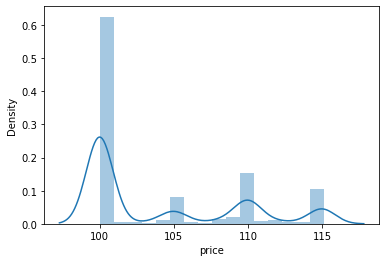

In [73]:
#let's see the distribution of prices in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(tax_114_paintings_df_temp['price'])

3) dimensions information (and weight): this is critical for modeling so I must process it and remove those that are missing such info
   item_length, item_width, item_height, dimension_unit, item_weight, weight_unit -> lenght, width, height, area (all in inches), weight (in oz), aspect ratio 

In [74]:
tax_114_paintings_df_temp['item_length'].isna()

0       False
1        True
2        True
3       False
4        True
        ...  
7847     True
7848     True
7849    False
7850     True
7851     True
Name: item_length, Length: 7852, dtype: bool

In [75]:
#I am not sure why the dimensions are missing from the table when if I look at the url it shows the dimensions...
tax_114_paintings_df_temp.iloc[0]['url']

'https://www.etsy.com/listing/935232277/original-watercolor-high-sensitivity'

In [76]:
tax_114_paintings_df_temp.iloc[0]

listing_id                                                                935232277
user_id                                                                    26499748
shop_id                                                                    17856190
title                             Original Watercolor, &quot;High Sensitivity&qu...
description                       &quot;High Sensitivity&quot; December, 2020\nI...
state                                                                        active
creation_timestamp                                                       1624712537
ending_timestamp                                                         1635253337
original_creation_timestamp                                              1609611379
last_modified_timestamp                                                  1624712537
state_timestamp                                                          1621909273
quantity                                                                    

In [77]:
tax_114_paintings_df_temp.iloc[4]['url']

'https://www.etsy.com/listing/491350938/fledgling-baby-bluejay-bird-original'

In [78]:
tax_114_paintings_df_temp.iloc[4]

listing_id                                                                491350938
user_id                                                                    86697924
shop_id                                                                    12997076
title                             Fledgling baby Bluejay bird Original Watercolo...
description                       The baby bluejay fledgling is an original wate...
state                                                                        active
creation_timestamp                                                       1628002868
ending_timestamp                                                         1638547268
original_creation_timestamp                                              1484241656
last_modified_timestamp                                                  1634904485
state_timestamp                                                          1617496509
quantity                                                                    

In [79]:
tax_114_paintings_df_temp['item_dimensions_unit'].unique()

array(['in', nan, 'mm'], dtype=object)

In [80]:
tax_114_paintings_df_temp['item_weight_unit'].unique()

array(['oz', nan, 'g'], dtype=object)

In [81]:
#Item dimensions are critical for estimating the price, so I am going to have to drop all the entries that have nan's in either item length or item width or item_dimensions_unit
#I do the same for weight since it's possible that there may be important information there (e.g. if the painting has a frame and is bigger it will weigh more)
tax_114_paintings_df_temp.dropna(axis=0,subset=['item_length','item_width','item_height','item_dimensions_unit','item_weight','item_weight_unit'],inplace=True)

In [82]:
len(tax_114_paintings_df_temp)

3334

In [83]:
#LEt's see an example of entry in which the units are mm
tax_114_paintings_df_temp[tax_114_paintings_df_temp['item_dimensions_unit']=='mm']['item_length']

265     500.0
568     250.0
812     500.0
2546    220.0
2908    500.0
3317    250.0
3474    250.0
6864    340.0
Name: item_length, dtype: float64

In [84]:
tax_114_paintings_df_temp.iloc[4][['item_length','item_width','item_dimensions_unit']]

item_length             26.0
item_width               4.0
item_dimensions_unit      in
Name: 12, dtype: object

In [85]:
#need to make sure this gets executed only once, so I drop the column with the units afterwards
tax_114_paintings_df_temp['length']=tax_114_paintings_df_temp[['item_length','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp['width']=tax_114_paintings_df_temp[['item_width','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp['height']=tax_114_paintings_df_temp[['item_height','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp.drop(['item_length','item_width','item_height','item_dimensions_unit'],axis=1,inplace=True)
#this is safer because sometimes people confuse height, length and width
tax_114_paintings_df_temp['max_dimension']=tax_114_paintings_df_temp[['width','length','height']].apply(lambda x:np.max(x), axis=1) 
tax_114_paintings_df_temp['area']=tax_114_paintings_df_temp[['width','length','height']].apply(lambda x:(np.max(x)*np.median(x)), axis=1) 
tax_114_paintings_df_temp['aspect_ratio']=tax_114_paintings_df_temp[['width','length','height']].apply(lambda x:(np.max(x)/np.median(x)), axis=1)

In [86]:
#similar processing for the weight
tax_114_paintings_df_temp['item_weight_unit'].unique()

array(['oz', 'g'], dtype=object)

In [87]:
tax_114_paintings_df_temp[tax_114_paintings_df_temp['item_weight_unit']=='g']['item_weight'][:4]

265     500.0
568      15.0
812     500.0
2546    500.0
Name: item_weight, dtype: float64

In [88]:
tax_114_paintings_df_temp['weight']=tax_114_paintings_df_temp[['item_weight','item_weight_unit']].apply(lambda x:x[0]/28.3495 if x[1]=='g' else x[0], axis=1)
tax_114_paintings_df_temp.drop(['item_weight','item_weight_unit'],axis=1,inplace=True)

In [89]:
tax_114_paintings_df_temp.describe()

,listing_id,user_id,shop_id,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,state_timestamp,quantity,shop_section_id,...,processing_max,price,taxonomy_id,length,width,height,max_dimension,area,aspect_ratio,weight
count,3.334000e+03,3.334000e+03,3.334000e+03,3.334000e+03,3.334000e+03,3.334000e+03,3.334000e+03,3.334000e+03,3334.000000,2.164000e+03,...,3269.000000,3334.000000,3334.0,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,8.232183e+08,1.288482e+08,1.650612e+07,1.629840e+09,1.640420e+09,1.580816e+09,1.630705e+09,1.601135e+09,7.712657,2.571741e+07,...,5.525849,103.681542,114.0,15.495803,9.861964,3.329454,15.495803,191.159709,1.553587,20.837833
std,2.122745e+08,1.398309e+08,7.682537e+06,3.136259e+06,3.139649e+06,5.432811e+07,2.941784e+06,3.655489e+07,59.271846,7.143462e+06,...,5.650226,5.429482,0.0,5.157904,5.110032,4.730027,5.157904,132.259002,1.398146,38.096154
min,1.951992e+07,1.067100e+04,5.009351e+06,1.604158e+09,1.614530e+09,1.231526e+09,1.616254e+09,1.416876e+09,1.000000,5.019832e+06,...,1.000000,100.000000,114.0,1.000000,0.003000,0.001000,1.000000,1.000000,1.000000,0.005000
25%,6.974015e+08,2.060912e+07,9.369959e+06,1.627329e+09,1.637960e+09,1.557729e+09,1.628398e+09,1.588756e+09,1.000000,2.136784e+07,...,3.000000,100.000000,114.0,12.000000,8.000000,1.000000,12.000000,108.000000,1.230769,6.000000
50%,8.539198e+08,7.164785e+07,1.651077e+07,1.629904e+09,1.640448e+09,1.598695e+09,1.631180e+09,1.613572e+09,1.000000,2.685278e+07,...,3.000000,100.000000,114.0,14.000000,10.000000,1.000000,14.000000,154.000000,1.285714,16.000000
75%,9.953502e+08,1.997090e+08,2.306360e+07,1.632501e+09,1.643045e+09,1.618416e+09,1.633246e+09,1.627480e+09,1.000000,3.146055e+07,...,5.000000,110.000000,114.0,18.000000,13.000000,3.702756,18.000000,225.000000,1.333333,18.000000
max,1.106428e+09,5.462409e+08,3.234194e+07,1.634878e+09,1.645508e+09,1.634862e+09,1.634901e+09,1.634862e+09,999.000000,3.580088e+07,...,50.000000,115.000000,114.0,48.000000,30.000000,32.000000,48.000000,1280.000000,18.000000,1120.000000


4) Info about when piece was created or added into the system - original_creation_timestamp, when_made

In [90]:
tax_114_paintings_df_temp['when_made'].unique()

array(['2020_2021', 'made_to_order', '2010_2019', 'before_2002', nan,
       '1970s', '1950s', '2002_2009', '1990s', '1910s', '1980s', '1930s',
       '1800s', '2000_2001', '1960s', '1900s', '1940s'], dtype=object)

In [91]:
grouped_by_made_period = tax_114_paintings_df_temp.groupby(by='when_made')

In [92]:
grouped_by_made_period['listing_id'].count()

when_made
1800s              11
1900s               2
1910s               1
1930s               4
1940s               6
1950s              15
1960s              11
1970s              25
1980s              33
1990s              21
2000_2001           4
2002_2009          27
2010_2019         966
2020_2021        1575
before_2002        39
made_to_order     531
Name: listing_id, dtype: int64

In [93]:
#it looks like the overwhelming majority of paintings is either done in the past 1-2 years or in the previous decade (2010-2019) so this variable may not be that informative.
#I can perhaps use this as categorical data with 4 categories like ['made_to_order','made_2020s','made_2010s','made_before_2010']
#First, let's check how many entries are missing the 'when made' tag to make sure we are not dropping too many cells if we decide to use this

In [94]:
sum(tax_114_paintings_df_temp['when_made'].isna())

63

In [95]:
#Drop the rows without 'when_made'
tax_114_paintings_df_temp.dropna(axis=0,subset=['when_made'],inplace=True)

In [96]:
def format_when_made(when_made):
    if when_made=='made_to_order':
        return 'made_to_order'
    elif when_made=='2020_2021':
        return 'made_2020s'
    elif when_made=='2010_2019':
        return 'made_2010s'
    else:
        return 'made_before_2010'

In [97]:
tax_114_paintings_df_temp['when_made']=tax_114_paintings_df_temp['when_made'].apply(lambda x:format_when_made(x)) #, axis=1)

In [98]:
tax_114_paintings_df_temp.iloc[38]

listing_id                                                                553380100
user_id                                                                    70990540
shop_id                                                                    16233460
title                                                                Cape in Winter
description                       Cape in Winter is a signed(20th c. artist)and ...
state                                                                        active
creation_timestamp                                                       1625847050
ending_timestamp                                                         1636477850
original_creation_timestamp                                              1508896037
last_modified_timestamp                                                  1625847050
state_timestamp                                                          1530949676
quantity                                                                    

In [99]:
#Next let's look at the age of a listing (which may or may not related to when the painting was actually created)

In [100]:
from datetime import datetime
#let's use end of the year as the reference day to which comparing every other date
ref_date = datetime.strptime('2021-Dec-31','%Y-%b-%d') 
ref_date

datetime.datetime(2021, 12, 31, 0, 0)

In [101]:
tax_114_paintings_df_temp['days_from_original_creation'] = tax_114_paintings_df_temp['original_creation_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

In [102]:
# #I decided to not use the time from last modification, as too dependent on when a particular listing was last downloaded
#tax_114_paintings_df_temp['days_from_last_modification'] = tax_114_paintings_df_temp['last_modified_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

In [103]:
tax_114_paintings_df_temp.describe()

,listing_id,user_id,shop_id,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,state_timestamp,quantity,shop_section_id,...,price,taxonomy_id,length,width,height,max_dimension,area,aspect_ratio,weight,days_from_original_creation
count,3.271000e+03,3.271000e+03,3.271000e+03,3.271000e+03,3.271000e+03,3.271000e+03,3.271000e+03,3.271000e+03,3271.000000,2.112000e+03,...,3271.000000,3271.0,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000
mean,8.264512e+08,1.300931e+08,1.658580e+07,1.629845e+09,1.640425e+09,1.581585e+09,1.630716e+09,1.601444e+09,7.810456,2.585746e+07,...,103.664097,114.0,15.502257,9.859497,3.333580,15.502257,191.597643,1.551800,20.709103,686.435952
std,2.120735e+08,1.405554e+08,7.696533e+06,3.150104e+06,3.153648e+06,5.414087e+07,2.949925e+06,3.655417e+07,59.813570,7.099992e+06,...,5.413159,0.0,5.158688,5.131071,4.745577,5.158688,132.755333,1.401285,38.327160,626.626895
min,1.951992e+07,1.067100e+04,5.009351e+06,1.604158e+09,1.614530e+09,1.231526e+09,1.616254e+09,1.416876e+09,1.000000,5.019832e+06,...,100.000000,114.0,1.000000,0.003000,0.001000,1.000000,1.000000,1.000000,0.005000,70.000000
25%,7.007768e+08,2.073982e+07,9.539829e+06,1.627268e+09,1.637899e+09,1.559159e+09,1.628396e+09,1.589332e+09,1.000000,2.141419e+07,...,100.000000,114.0,12.000000,8.000000,1.000000,12.000000,108.000000,1.230769,6.000000,251.000000
50%,8.586279e+08,7.219861e+07,1.651077e+07,1.629910e+09,1.640454e+09,1.599595e+09,1.631218e+09,1.614082e+09,1.000000,2.703959e+07,...,100.000000,114.0,14.000000,10.000000,1.000000,14.000000,154.000000,1.285714,16.000000,478.000000
75%,9.978842e+08,2.022689e+08,2.313853e+07,1.632525e+09,1.643070e+09,1.619216e+09,1.633275e+09,1.627504e+09,1.000000,3.164337e+07,...,110.000000,114.0,18.000000,13.000000,3.000000,18.000000,225.000000,1.333333,17.000000,946.000000
max,1.106428e+09,5.462409e+08,3.234194e+07,1.634878e+09,1.645508e+09,1.634862e+09,1.634901e+09,1.634862e+09,999.000000,3.580088e+07,...,115.000000,114.0,48.000000,30.000000,32.000000,48.000000,1280.000000,18.000000,1120.000000,4738.000000


In [104]:
#I can now drop all the other timestamp variables
tax_114_paintings_df_temp.drop(['creation_timestamp','ending_timestamp','original_creation_timestamp','last_modified_timestamp','state_timestamp'],axis=1,inplace=True)

In [105]:
tax_114_paintings_df_temp.describe()

,listing_id,user_id,shop_id,quantity,shop_section_id,featured_rank,num_favorers,personalization_char_count_max,listing_type,shipping_profile_id,...,price,taxonomy_id,length,width,height,max_dimension,area,aspect_ratio,weight,days_from_original_creation
count,3.271000e+03,3.271000e+03,3.271000e+03,3271.000000,2.112000e+03,3271.00000,3271.000000,225.000000,3271.000000,2.494000e+03,...,3271.000000,3271.0,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000
mean,8.264512e+08,1.300931e+08,1.658580e+07,7.810456,2.585746e+07,-0.29410,5.645980,273.777778,0.000611,8.913027e+10,...,103.664097,114.0,15.502257,9.859497,3.333580,15.502257,191.597643,1.551800,20.709103,686.435952
std,2.120735e+08,1.405554e+08,7.696533e+06,59.813570,7.099992e+06,7.60394,34.847453,114.026800,0.024723,4.163094e+10,...,5.413159,0.0,5.158688,5.131071,4.745577,5.158688,132.755333,1.401285,38.327160,626.626895
min,1.951992e+07,1.067100e+04,5.009351e+06,1.000000,5.019832e+06,-1.00000,0.000000,80.000000,0.000000,3.225529e+06,...,100.000000,114.0,1.000000,0.003000,0.001000,1.000000,1.000000,1.000000,0.005000,70.000000
25%,7.007768e+08,2.073982e+07,9.539829e+06,1.000000,2.141419e+07,-1.00000,0.000000,256.000000,0.000000,5.941612e+10,...,100.000000,114.0,12.000000,8.000000,1.000000,12.000000,108.000000,1.230769,6.000000,251.000000
50%,8.586279e+08,7.219861e+07,1.651077e+07,1.000000,2.703959e+07,-1.00000,1.000000,256.000000,0.000000,8.827741e+10,...,100.000000,114.0,14.000000,10.000000,1.000000,14.000000,154.000000,1.285714,16.000000,478.000000
75%,9.978842e+08,2.022689e+08,2.313853e+07,1.000000,3.164337e+07,-1.00000,4.000000,256.000000,0.000000,1.273275e+11,...,110.000000,114.0,18.000000,13.000000,3.000000,18.000000,225.000000,1.333333,17.000000,946.000000
max,1.106428e+09,5.462409e+08,3.234194e+07,999.000000,3.580088e+07,204.00000,1335.000000,1024.000000,1.000000,1.558161e+11,...,115.000000,114.0,48.000000,30.000000,32.000000,48.000000,1280.000000,18.000000,1120.000000,4738.000000


5) Rankings given by either the seller or users: 'featured_rank', 'num_favorers'

In [106]:
#How many paintings have favorers
tax_114_paintings_df_temp['num_favorers'].unique()

array([   2,    1,    3,    0,   26,    8,    4,   19,   27,   11,   20,
         18,  766,    9,   12,    7,    6,   17,   10,    5,   16,   14,
         37,   13,   33,   22,   39,   30,   29,   40,   21,   36,   31,
         25,   15,  143,   38,   63,   28,   65,  295,  109,   57,   68,
         24,   34,   56,  275,   41,   23,   76,   48,   50,   70,   73,
         32,   35,   62,   83,   44,   42,   47,  159,  288,  454,  111,
        121,  191,  128,  233,   46,  249,   92,  230,  261,  738,  147,
       1335], dtype=int64)

In [107]:
#many paintings have non-zero number of favorers, so this may be a useful attribute
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['num_favorers']>0])

2047

In [108]:
#However, is it missing in many paintings? No
sum(tax_114_paintings_df_temp['num_favorers'].isna())

0

In [109]:
#Let's check featured_rank:
tax_114_paintings_df_temp['featured_rank'].unique()

array([ -1,   0,   1,   3,   2,   5,   4,  18,  10, 134, 180,  19,   8,
        11,   6,  32,   7,  12,  13, 179,  17,  23,   9, 142, 123, 204,
        28,  97,  24,  16,  78,  50,  15], dtype=int64)

In [110]:
#many paintings have featured_rank different from default -1? Not very many, but it may be important and it is not missing in any entry, so I will leave this alone
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['featured_rank']!=-1])

248

In [111]:
sum(tax_114_paintings_df_temp['featured_rank'].isna())

0

6) A bunch of misc variable that may or may not matter, most of whilch I'll remove except the first few

In [112]:
#Who made the painting? Seller or somebody else?
tax_114_paintings_df_temp['who_made'].value_counts()

i_did           3086
someone_else     145
collective        40
Name: who_made, dtype: int64

In [113]:
#Let's redefine the above as a boolean: seller made TRUE or FALSE (if someone_else or collective made it)
tax_114_paintings_df_temp['made_by_seller']=tax_114_paintings_df_temp['who_made'].apply(lambda x:True if 'i_did' else False) #, axis=1)

In [114]:
#Drop the original column
tax_114_paintings_df_temp.drop(['who_made'],axis=1,inplace=True)

In [115]:
#Quantity - I am not sure these numbers always make sense (999?) and the quantity presumably changes all the time.
#moreover, most of the paintings have only quantity 1, and the other numbers vary a lot, so I will remove this 
tax_114_paintings_df_temp['quantity'].unique()

array([  1,  99,   9,  20,  48,  73,  95,   3,   5, 100,  10,  15,   4,
        24, 999,  25,  96,   2,  78,  32,   6,  98,  49, 945,  30,  18,
        50,  12,  94,   7,  55,  97,  59,  39,  14,   8,  16,  47,  17,
        80,  13,  44,  91, 284, 149, 150,  45,  46, 998,  19,  93,  60,
        77,  11,  23, 293, 495,  28,  71, 920], dtype=int64)

In [116]:
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['quantity']>1])

414

In [117]:
sum(tax_114_paintings_df_temp['quantity'].isna())

0

In [118]:
#Listing type - this is almost exclusively equal 0, so I will drop this
tax_114_paintings_df_temp['listing_type'].unique()

array([0, 1], dtype=int64)

In [119]:
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['listing_type']==1])

2

In [120]:
#Non-taxable - very few entries are true, so I will drop this
tax_114_paintings_df_temp['non_taxable'].value_counts()

False    3234
True       37
Name: non_taxable, dtype: int64

In [121]:
#Is personalizable - very few entries are true, so I will drop this
tax_114_paintings_df_temp['is_personalizable'].value_counts()

False    3067
True      204
Name: is_personalizable, dtype: int64

In [122]:
#personalization_is_required - very few entries are true, so I will drop this (along with the other 'personalization' info)
tax_114_paintings_df_temp['personalization_is_required'].value_counts()

False    3136
True      135
Name: personalization_is_required, dtype: int64

In [123]:
#is_supply - very few entries are true, so I will drop this (along with the other )
tax_114_paintings_df_temp['is_supply'].value_counts()

False    3267
True        4
Name: is_supply, dtype: int64

In [124]:
#is_private - no entries are true, so I will drop this (along with the other )
tax_114_paintings_df_temp['is_private'].value_counts()

False    3271
Name: is_private, dtype: int64

In [125]:
#is_customizable - almost 500 entries are true, so I will leave this alone (and I have already discarded the 'is_personalizable' one)
tax_114_paintings_df_temp['is_customizable'].value_counts()

False    2803
True      468
Name: is_customizable, dtype: int64

In [126]:
 #has_variations - decent number of entries entries are true, so I will leave this alone
tax_114_paintings_df_temp['has_variations'].value_counts()

False    2746
True      525
Name: has_variations, dtype: int64

In [127]:
#Here is where I drop at once the columns discussed above:
tax_114_paintings_df_temp.drop(['quantity','listing_type','non_taxable','is_personalizable','personalization_is_required','is_supply','is_private'],axis=1,inplace=True)

In [128]:
#Also drop a bunch of other things that don't matter:

In [129]:
tax_114_paintings_df_temp.drop(['state','personalization_char_count_max','personalization_instructions','processing_min','processing_max','should_auto_renew','language','production_partners','file_data'],axis=1,inplace=True)

In [130]:
tax_114_paintings_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3271 entries, 0 to 7849
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   3271 non-null   int64  
 1   user_id                      3271 non-null   int64  
 2   shop_id                      3271 non-null   int64  
 3   title                        3271 non-null   object 
 4   description                  3271 non-null   object 
 5   shop_section_id              2112 non-null   float64
 6   featured_rank                3271 non-null   int64  
 7   url                          3271 non-null   object 
 8   num_favorers                 3271 non-null   int64  
 9   is_customizable              3271 non-null   bool   
 10  tags                         3271 non-null   object 
 11  materials                    3271 non-null   object 
 12  shipping_profile_id          2494 non-null   float64
 13  when_made         

7) Look at 'tags', 'materials' and 'style', word tags that are added in some of the paintings

In [131]:
#The 'materials' tag seems to be a bit redundant (mostly watercolors, paper, etc.) to the taxonomy number 
#and there may be problems due to different spellings - for now I will keep this column as is but further process it later
tax_114_paintings_df_temp['materials'].value_counts()[:20]

['Paper']                                                                                                                                                           1335
[]                                                                                                                                                                   878
['watercolor']                                                                                                                                                        62
['watercolor', 'paper']                                                                                                                                               49
['Canvas board']                                                                                                                                                      26
['Stretched canvas']                                                                                                                                       

In [132]:
#The style tags are added only in a limited number of cases, but I leave them alone and further process them later
tax_114_paintings_df_temp['style'].value_counts()[:20]

[]                              3134
['African', 'Modern']             17
['Cottage Chic', 'Abstract']       7
['Southwestern']                   6
['Traditional', 'whimsical']       6
['Avant Garde', 'Boho']            6
['Abstract', 'Primitive']          6
['Traditional']                    6
['Fantasy', 'Woodland']            5
['Southwestern', 'Woodland']       5
['Woodland', 'Southwestern']       4
['Abstract']                       3
['Beach', 'Zen']                   3
['Nautical', 'Traditional']        3
['Cottage Chic']                   3
['Fantasy', 'Folk']                2
['Zen', 'Asian']                   2
['Rustic', 'Woodland']             2
['Traditional', 'Art Deco']        2
['Southwestern', 'Abstract']       2
Name: style, dtype: int64

In [133]:
#The generic 'tags' may (or may not) add valuable info but are messy - for now I'll leave them alone -  but I will try to do something smart with this later in machine-learning
tax_114_paintings_df_temp['tags'].value_counts()[:20]

[]                                                                                                                                                                                                                                                                  421
['custom home portrait', 'house portrait', 'home portrait', 'custom watercolor', 'home from photo', 'house from photo', 'house painting', 'home painting', 'home drawing', 'home watercolor', 'custom house drawing', 'house watercolor', 'custom home drawing']     33
['Landscape', 'rectangle', 'KaylaInfernoArt', 'Colorado', 'nature', 'watercolor', 'fine art', 'colorful colorado', 'painting', 'original', 'sketch', 'plein air', 'watercolour']                                                                                     29
['Original', 'Watercolor', 'Plants', 'Flowers', 'Botanic', 'Fresh', 'One-of-a-Kind', 'Abstract', 'Floral', 'Painting', 'Bold', 'Unique', 'Wall Art']                                                            

8) Finally I will take care of taxonomy in the way discussed earlier, leaving only 4 types: 'Oil', 'Watercolor', 'Acrylic' and 'More than one' 

In [134]:
tax_114_paintings_df_temp['taxonomy_id'].value_counts()

114    3271
Name: taxonomy_id, dtype: int64

In [135]:
def format_taxonomy_id(taxonomy_id):
    if taxonomy_id==106:
        return 'acrylic'
    elif taxonomy_id==112:
        return 'oil'
    elif taxonomy_id==114:
        return 'watercolor'
    elif taxonomy_id in [107,111]:
        return 'more_than_one'
    else:
        return 'other'

In [136]:
tax_114_paintings_df_temp['painting_type']=tax_114_paintings_df_temp['taxonomy_id'].apply(lambda x:format_taxonomy_id(x)) #, axis=1)

In [137]:
tax_114_paintings_df_temp['painting_type'].value_counts()

watercolor    3271
Name: painting_type, dtype: int64

In [138]:
#So at the end of this cleaning procedure, the first set of ~8000 watercolor paintings (with 45 fields pf information) got reduced to 
#~3000 paintings with ~25 fields of information plus the price target column

In [139]:
len(tax_114_paintings_df_temp)

3271

In [140]:
#Of the remaining fields of information, 7 are just useful to identify the artifact (the _id's and url), 
# 5 are textual descriptions/tags not all of which are likely  helpful (title, description, tags, materials, style),
# 10 are numerical features that will be used in the predictor: featured_rank, num_favorers, length, width, height, area, aspect_ratio, weight, days_from_original_creation
# 2 are categorical features that will be used in the predictor: painting_type (4 categories), when_made (4 categories)
# 3 are boolean features: is_customizable, has_variations, made_by_seller

In [141]:
tax_114_paintings_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3271 entries, 0 to 7849
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   3271 non-null   int64  
 1   user_id                      3271 non-null   int64  
 2   shop_id                      3271 non-null   int64  
 3   title                        3271 non-null   object 
 4   description                  3271 non-null   object 
 5   shop_section_id              2112 non-null   float64
 6   featured_rank                3271 non-null   int64  
 7   url                          3271 non-null   object 
 8   num_favorers                 3271 non-null   int64  
 9   is_customizable              3271 non-null   bool   
 10  tags                         3271 non-null   object 
 11  materials                    3271 non-null   object 
 12  shipping_profile_id          2494 non-null   float64
 13  when_made         

### Encapsulate all the preprocessing steps into a single function to be applied to each .csv file of raw data

In [142]:
from datetime import datetime

def format_dimensions(dimension_unit_vec):
    if dimension_unit_vec[1]=='in':
        return dimension_unit_vec[0]
    elif dimension_unit_vec[1]=='mm':
        return dimension_unit_vec[0]/25.4
    elif dimension_unit_vec[1]=='cm':
        return dimension_unit_vec[0]/2.54
    else:
        print(f'measurement unit {dimension_unit_vec[1]} not supported for dimensions')

def format_weight(weight_unit_vec):
    if weight_unit_vec[1]=='oz':
        return weight_unit_vec[0]
    elif weight_unit_vec[1]=='g':
        return weight_unit_vec[0]/28.3495
    else:
        print(f'measurement unit {weight_unit_vec[1]} not supported for weight')
        
def format_when_made(when_made):
    if when_made=='made_to_order':
        return 'made_to_order'
    elif when_made=='2020_2021':
        return 'made_2020s'
    elif when_made=='2010_2019':
        return 'made_2010s'
    else:
        return 'made_before_2010'
    
def format_taxonomy_id(taxonomy_id):
    if taxonomy_id==106:
        return 'acrylic'
    elif taxonomy_id==112:
        return 'oil'
    elif taxonomy_id==114:
        return 'watercolor'
    elif taxonomy_id in [107,111]:
        return 'more_than_one'
    else:
        return 'other'

def clean_listings_dataframe(paintings_orig_df_by_taxonomy):

    #This function will drop the paintings without dimensions info and 'when_made' information.
    #Then for all remaining entries the info is consolidated into 27 fields of information in addition to the target column 'price':
    # 7 fields are just useful to identify the artifact (the _id's and url), 
    # 5 are textual descriptions/tags that are unlikely to be very helpful (title, description, tags, materials, style),
    # 10 are numerical features that will be used in the predictor: featured_rank, num_favorers, length, width, height, area, aspect_ratio, weight, days_from_original_creation, days_from_last_modifications
    # 2 are categorical features that will be used in the predictor: painting_type (4 categories), when_made (4 categories)
    # 3 are boolean features: is_customizable, has_variations, made_by_seller

    #1) Item dimensions are critical for estimating the price, so I am going to have to drop all the entries that have nan's in either item length or item width or item_dimensions_unit
    #I do the same for weight since it's possible that there may be important information there (e.g. if the painting has a frame and is bigger it will weigh more)
    paintings_orig_df_by_taxonomy.dropna(axis=0,subset=['item_length','item_width','item_height','item_dimensions_unit','item_weight','item_weight_unit'],inplace=True)

    #2) process all the dimensions (converting measurement units, etc.) as follows, also creating new columns 'area' and 'aspect_ratio' (defined by max dim/2nd dimension)
    #need to make sure this gets executed only once, so I drop the column with the units afterwards
    paintings_orig_df_by_taxonomy['length']=paintings_orig_df_by_taxonomy[['item_length','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy['width']=paintings_orig_df_by_taxonomy[['item_width','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy['height']=paintings_orig_df_by_taxonomy[['item_height','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy.drop(['item_length','item_width','item_height','item_dimensions_unit'],axis=1,inplace=True)
    #this is safer because sometimes people confuse height, length and width
    paintings_orig_df_by_taxonomy['max_dimension']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:np.max(x), axis=1) 
    paintings_orig_df_by_taxonomy['area']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:(np.max(x)*np.median(x)), axis=1) 
    paintings_orig_df_by_taxonomy['aspect_ratio']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:(np.max(x)/np.median(x)), axis=1)
    #I also drop the height, width, length fields since they are not very reliable (many users appear to mistake which is which) and the data is already
    #contained in the new and more reliable variables 'max_dimension', 'area', 'aspect_ratio'
    paintings_orig_df_by_taxonomy.drop(['length','width','height'],axis=1,inplace=True)
    
    #3) process the weight also, by consolidating units and renaming the column 
    paintings_orig_df_by_taxonomy['weight']=paintings_orig_df_by_taxonomy[['item_weight','item_weight_unit']].apply(lambda x:format_weight(x), axis=1)
    paintings_orig_df_by_taxonomy.drop(['item_weight','item_weight_unit'],axis=1,inplace=True)

    #4) The overwhelming majority of paintings is either done in the past 1-2 years or in the previous decade (2010-2019).
    #Create categorical feature with 4 categories like ['made_to_order','made_2020s','made_2010s','made_before_2010'] using the original 'when_made' column
    #Drop the rows without 'when_made'
    paintings_orig_df_by_taxonomy.dropna(axis=0,subset=['when_made'],inplace=True)   
    paintings_orig_df_by_taxonomy['when_made']=paintings_orig_df_by_taxonomy['when_made'].apply(lambda x:format_when_made(x)) #, axis=1)

    #5) Convert timestamps for original creation and last modification into number of days from the end of 2021
    ref_date = datetime.strptime('2021-Dec-31','%Y-%b-%d') 
    paintings_orig_df_by_taxonomy['days_from_original_creation'] = paintings_orig_df_by_taxonomy['original_creation_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)
    # I ended up removing this variable as it was mostly a function of when I downloaded the data
    #paintings_orig_df_by_taxonomy['days_from_last_modification'] = paintings_orig_df_by_taxonomy['last_modified_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

    #6) Drop all the other timestamp variables
    paintings_orig_df_by_taxonomy.drop(['creation_timestamp','ending_timestamp','original_creation_timestamp','last_modified_timestamp','state_timestamp'],axis=1,inplace=True)

    #7) Fill the missing values for 'num_favorers' and 'featured_rank' (if any) with the default values 0 and -1 respectively, and the 'who_made' missing values with 'i_did',
    #since these are the overwhelmingly must common cases
    paintings_orig_df_by_taxonomy['num_favorers'].fillna(value=0,inplace=True)
    paintings_orig_df_by_taxonomy['featured_rank'].fillna(value=-1,inplace=True)
    paintings_orig_df_by_taxonomy['who_made'].fillna(value='i_did',inplace=True)
    
    #8) Redefine the 'who_made' variable as a boolean: seller made TRUE or FALSE (if someone_else or collective made it)
    paintings_orig_df_by_taxonomy['made_by_seller']=paintings_orig_df_by_taxonomy['who_made'].apply(lambda x:True if x=='i_did' else False) #, axis=1)
    #Drop the original column
    paintings_orig_df_by_taxonomy.drop(['who_made'],axis=1,inplace=True)

    #9) Drop a bunch of columns that are standard for the great majority of the paintings
    paintings_orig_df_by_taxonomy.drop(['quantity','listing_type','non_taxable','is_personalizable','personalization_is_required','is_supply','is_private'],axis=1,inplace=True)

    #10) Drop a bunch of other info that doesn't matter for the model:
    paintings_orig_df_by_taxonomy.drop(['state','personalization_char_count_max','personalization_instructions','processing_min','processing_max','should_auto_renew','language','production_partners','file_data'],axis=1,inplace=True)

    #11) Create a new 'painting_type' categorical value from 'taxonomy_id' with only 4 categories: acrylic, oil, watercolor, more_than_one
    #(I keep the 'taxonomy_id' column also as an identifier of the item like listing_id, user_id, shop_id, etc.)   
    paintings_orig_df_by_taxonomy['painting_type']=paintings_orig_df_by_taxonomy['taxonomy_id'].apply(lambda x:format_taxonomy_id(x)) #, axis=1)

    #Note: I am leaving alone the 'free text' columns such as 'title', 'description', 'tags', 'materials' and 'style' for later use




In [143]:
#Test the previous procedure on the second subset of watercolor paintings to make sure it works as expected:

taxonomy_id = 114

csv_filename_pattern = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'
tax_csv_files = glob.glob(csv_filename_pattern)
tax_114_paintings_df_temp_2 = pd.read_csv(tax_csv_files[1])

In [144]:
len(tax_114_paintings_df_temp_2)

7089

In [145]:
tax_114_paintings_df_temp_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7089 entries, 0 to 7088
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   listing_id                      7089 non-null   int64  
 1   user_id                         7089 non-null   int64  
 2   shop_id                         7089 non-null   int64  
 3   title                           7089 non-null   object 
 4   description                     7089 non-null   object 
 5   state                           7089 non-null   object 
 6   creation_timestamp              7089 non-null   int64  
 7   ending_timestamp                7089 non-null   int64  
 8   original_creation_timestamp     7089 non-null   int64  
 9   last_modified_timestamp         7089 non-null   int64  
 10  state_timestamp                 7089 non-null   int64  
 11  quantity                        7089 non-null   int64  
 12  shop_section_id                 52

In [146]:
clean_listings_dataframe(tax_114_paintings_df_temp_2)

In [147]:
len(tax_114_paintings_df_temp_2)

2910

In [148]:
tax_114_paintings_df_temp_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2910 entries, 18 to 7088
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   2910 non-null   int64  
 1   user_id                      2910 non-null   int64  
 2   shop_id                      2910 non-null   int64  
 3   title                        2910 non-null   object 
 4   description                  2910 non-null   object 
 5   shop_section_id              1921 non-null   float64
 6   featured_rank                2910 non-null   int64  
 7   url                          2910 non-null   object 
 8   num_favorers                 2910 non-null   int64  
 9   is_customizable              2910 non-null   bool   
 10  tags                         2910 non-null   object 
 11  materials                    2910 non-null   object 
 12  shipping_profile_id          2229 non-null   float64
 13  when_made        

In [149]:
#So at the end of this cleaning procedure, the second set of ~7000 watercolor paintings (with 45 fields pf information) got reduced to 
#3000 paintings with ~24 fields of information plus the price target column

### Here is the iteration applying the cleaning procedure to all paintings of all taxonomies of interest, and creating a unique dataframe to carry forward for machine learning

In [150]:
import glob

#I will drop all the minor taxonomies that have less than 1000 paintings each, combine 107 (Combination) and 111 (Mixed) in a new 'More than one' category and will at the end
#have 4 categories with the main taxonomies (106=acrylic, 112=oil, 114=watercolor) + 'more_than_one'

#Note: this will combine all paintings in both the $100-250 and $250-750 ranges
min_price = 100.0 
# #Use this instead to only consider the reduced dataset with paintings having price >=$250
#min_price = 250.0

csv_combined_filename = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'
    
#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    all_paintings_df = pd.read_csv(csv_combined_filename)

    print(f'Loaded listings file {csv_combined_filename} with all the cleaned listings (multiple taxonomies).')

except FileNotFoundError:
    
    try: #it by any chance there is a version of 'all_paintings_df' around, I delete it
        del all_paintings_df
    except NameError:
        pass

    taxonomies_of_interest = [106, 107, 111, 112, 114]

    for taxonomy_id in taxonomies_of_interest:

        csv_filename_pattern_tax_id = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'
        tax_id_csv_files = glob.glob(csv_filename_pattern_tax_id)

        for csv_file in tax_id_csv_files:

            tax_id_paintings_df_temp = pd.read_csv(csv_file)

            clean_listings_dataframe(tax_id_paintings_df_temp)

            try: #concatenate to the other
                all_paintings_df = pd.concat([all_paintings_df, tax_id_paintings_df_temp])
            except NameError: #if it's the first iteration, I need to create the dataframe where the data of all paintings of all taxonomies will be stored
                all_paintings_df = tax_id_paintings_df_temp

    #because of the imbalance in prices (watercolors only had paintings up to 672$, oil up to 700$, acrylic up to 750$ and 'more_than_one' up to 662$), 
    #I only keep paintings with price <= 650$
    all_paintings_df = all_paintings_df[all_paintings_df['price']<=650.0]
    
    #drop all paintings with largest dimension >72in, as those are outliers (there were a few of these)
    all_paintings_df = all_paintings_df[all_paintings_df['max_dimension']<=72.0]

    #remove any duplicate listings that may be present (there were several)
    all_paintings_df.drop_duplicates(subset='listing_id',keep='first',inplace=True)
    
    #sort by price in ascending order, with listing_id used next to break ties - this should shuffle the 4 painting types
    all_paintings_df.sort_values(by=['price','listing_id'], ascending=True, inplace=True)
  
    #reset index (dropping old indices that are meaningless)
    all_paintings_df.reset_index(drop=True, inplace=True)
    
    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    all_paintings_df.to_csv(csv_combined_filename,index=False)
    print(f'Saved listings file {csv_combined_filename} with all the cleaned listings (multiple taxonomies).')
    
    

Loaded listings file ./Git_exclude/Data/all_paintings_from_USD100_cleaned_listings.csv with all the cleaned listings (multiple taxonomies).


In [151]:
len(all_paintings_df)

119583

In [152]:
all_paintings_df.head(100)

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,has_variations,price,taxonomy_id,max_dimension,area,aspect_ratio,weight,days_from_original_creation,made_by_seller,painting_type
0,18131517,6081676,5342448,"ORIGINAL Painting,6&quot;x6&quot; Yellow Red A...","ORIGINAL Painting,6&quot;x6&quot; Yellow Red A...",5865531.0,-1,https://www.etsy.com/listing/18131517/original...,651,False,...,False,100.0,106,9.25,57.8125,1.480000,8.5,4776,True,acrylic
1,18796349,6081676,5342448,"ORIGINAL Painting, 6&quot;x 6&quot; Red Blue Y...","ORIGINAL Painting, 6&quot;x 6&quot; Red Blue Y...",5865531.0,-1,https://www.etsy.com/listing/18796349/original...,788,False,...,False,100.0,106,9.25,57.8125,1.480000,8.5,4762,True,acrylic
2,20875694,6081676,5342448,"ORIGINAL Painting, 6&quot;x 6&quot; Green Red ...","ORIGINAL Painting, 6&quot;x 6&quot; Green Red ...",5865531.0,-1,https://www.etsy.com/listing/20875694/original...,698,False,...,False,100.0,106,9.25,57.8125,1.480000,8.5,4706,True,acrylic
3,20875764,6081676,5342448,"ORIGINAL Painting, 6&quot; x 6&quot; Purple Bl...","ORIGINAL Painting, 6&quot; x 6&quot; Purple Bl...",5865531.0,-1,https://www.etsy.com/listing/20875764/original...,890,False,...,False,100.0,106,9.25,57.8125,1.480000,8.5,4706,True,acrylic
4,21020610,6392332,5392165,"Ocean Painting, Popular Right Now, Fishing Boa...","Ocean Painting, Popular Right Now, Water Paint...",18130058.0,-1,https://www.etsy.com/listing/21020610/ocean-pa...,335,True,...,False,100.0,106,12.00,144.0000,1.000000,48.0,4703,True,acrylic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,230359554,17583923,7094569,Ava Gardner Original Large Watercolor 22 x 30 ...,This is a watercolor painting of the immortal ...,12122638.0,-1,https://www.etsy.com/listing/230359554/ava-gar...,8,True,...,False,100.0,114,33.00,825.0000,1.320000,32.0,2448,True,watercolor
96,230696741,56065833,11020149,Rouge Orb,Hand done Watercolor painting on Cold Press,27853031.0,-1,https://www.etsy.com/listing/230696741/rouge-orb,4,False,...,False,100.0,114,10.00,100.0000,1.000000,16.0,2445,True,watercolor
97,230864377,21185529,10286017,"Original Oil Painting, size 12&quot;x12&quot;,...",I painted this at a California Art Club paint ...,17156836.0,-1,https://www.etsy.com/listing/230864377/origina...,8,False,...,False,100.0,111,21.00,315.0000,1.400000,16.0,2444,True,more_than_one
98,231357839,6392332,5392165,"Best Seller, Fall, Autumn, Birch Trees, Aspen ...",Birch Trees on a Fall Afternoon\n\nAre you mis...,18130058.0,-1,https://www.etsy.com/listing/231357839/best-se...,496,True,...,False,100.0,106,12.00,144.0000,1.000000,48.0,2440,True,acrylic


# PART 3: Preliminary analysis - and further preselection/preprocessing - of combined data from all paintings of all taxonomies of interest

In [153]:
#Let's check the distribution of painting types:
all_paintings_df['taxonomy_id'].value_counts()

106    57673
112    34976
114    19291
111     4234
107     3409
Name: taxonomy_id, dtype: int64

In [154]:
all_paintings_df['painting_type'].value_counts()

acrylic          57673
oil              34976
watercolor       19291
more_than_one     7643
Name: painting_type, dtype: int64

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


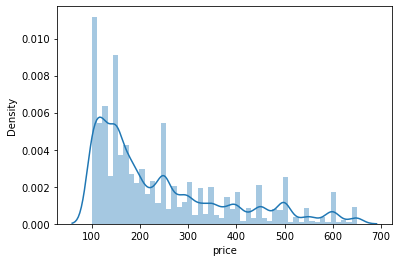

In [339]:
#Let's check the range of prices I have, especially for each painting type

sns.distplot(all_paintings_df['price'])
plt.savefig('./Git_exclude/Figures/distrib_prices.png', dpi=300)

<AxesSubplot:xlabel='price', ylabel='Count'>

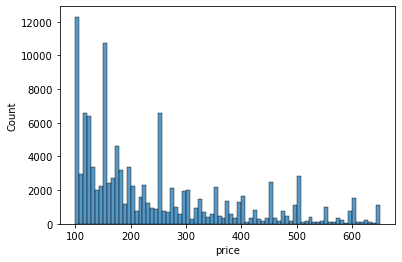

In [156]:
sns.histplot(all_paintings_df['price'])

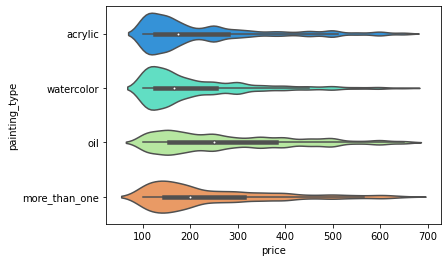

In [340]:
#Let's plot by painting type 
sns.violinplot(x="price", y="painting_type", data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/distrib_prices_by_type.png', dpi=300)

In [158]:
all_paintings_df.groupby(by='painting_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
painting_type,,,,,,,,
acrylic,57673.0,228.070811,138.121458,100.0,125.0,175.0,279.99,650.0
more_than_one,7643.0,242.798321,135.836404,100.0,145.0,199.0,313.00,650.0
oil,34976.0,278.683472,144.418108,100.0,155.0,249.0,380.00,650.0
watercolor,19291.0,210.678207,117.633575,100.0,125.0,165.0,255.00,650.0


In [159]:
all_paintings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119583 entries, 0 to 119582
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   119583 non-null  int64  
 1   user_id                      119583 non-null  int64  
 2   shop_id                      119583 non-null  int64  
 3   title                        119582 non-null  object 
 4   description                  119583 non-null  object 
 5   shop_section_id              69873 non-null   float64
 6   featured_rank                119583 non-null  int64  
 7   url                          119583 non-null  object 
 8   num_favorers                 119583 non-null  int64  
 9   is_customizable              119583 non-null  bool   
 10  tags                         119583 non-null  object 
 11  materials                    119583 non-null  object 
 12  shipping_profile_id          83488 non-null   float64
 13 

#### Further analysis of individual features

Numerical features

1) Dependence of price on painting dimensions

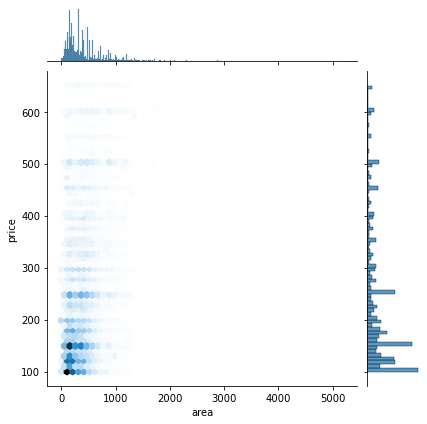

In [160]:
sns.jointplot(x='area',y='price',data=all_paintings_df,kind='hex')

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='area', ylabel='Density'>

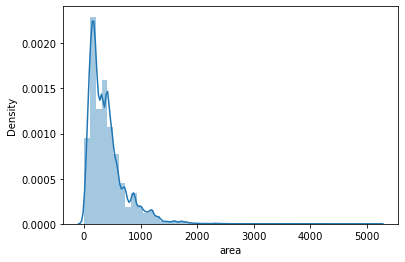

In [161]:
sns.distplot(all_paintings_df['area'])

In [162]:
pd.set_option('display.max_colwidth',100)
all_paintings_df.sort_values(by='area', ascending=False)[['max_dimension','aspect_ratio','area','weight','price','url']].head(20)

,max_dimension,aspect_ratio,area,weight,price,url
119417,72.0,1.000000,5184.0,320.0,650.00,https://www.etsy.com/listing/1026010266/extra-large-resin-art-blue-silver-gold
100638,70.0,1.000000,4900.0,240.0,399.99,https://www.etsy.com/listing/861168516/dazzling-acrylic-pour-on-40x60-gallery
110831,70.0,1.000000,4900.0,17.0,500.00,https://www.etsy.com/listing/731318345/personalized-gift-hand-made-portrait
116826,68.0,1.000000,4624.0,64.0,600.00,https://www.etsy.com/listing/720657853/sparrow-diamond
89753,65.0,1.000000,4225.0,640.0,310.00,https://www.etsy.com/listing/661729775/abstract-painting
118713,70.0,1.166667,4200.0,240.0,650.00,https://www.etsy.com/listing/596452185/tiger-extra-large-acrylic-painting-sabir
104480,70.0,1.166667,4200.0,240.0,450.00,https://www.etsy.com/listing/157110151/art-fairy-painting-green-forest-painting
94433,70.0,1.166667,4200.0,240.0,350.00,https://www.etsy.com/listing/582637862/abstract-acrylic-painting-snowy-day
110200,70.0,1.166667,4200.0,160.0,500.00,https://www.etsy.com/listing/541786250/soulmate
101221,70.0,1.206897,4060.0,160.0,400.00,https://www.etsy.com/listing/737245543/sold-brown-3-piece-geode-art


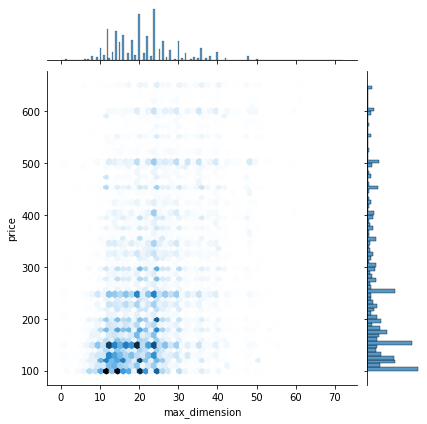

In [341]:
sns.jointplot(x='max_dimension',y='price',data=all_paintings_df,kind='hex')
plt.savefig('./Git_exclude/Figures/prices_vs_maxdim_scatter.png', dpi=300)

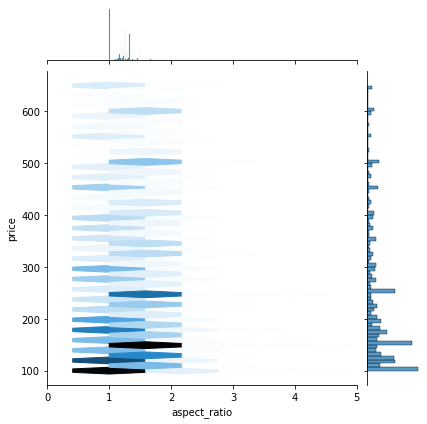

In [164]:
#aspect ratio does not look that informative
sns.jointplot(x='aspect_ratio',y='price',data=all_paintings_df,kind='hex',xlim=[0,5])

In [165]:
all_paintings_df.sort_values(by='aspect_ratio', ascending=False)[['max_dimension','aspect_ratio','area','weight','price','url']].head(20)

,max_dimension,aspect_ratio,area,weight,price,url
14529,12.0,60.0000,2.40,0.9,110.0,https://www.etsy.com/listing/1071322391/12x12-geometric-painting-canvas-wall-art
38644,24.0,48.0000,12.00,144.0,150.0,https://www.etsy.com/listing/774526976/handmade-barn-quilt
46243,14.5,45.3125,4.64,8.0,155.0,https://www.etsy.com/listing/1041339213/tender-innocence
109393,37.0,37.0000,37.00,80.0,495.0,https://www.etsy.com/listing/1028839365/bear-painting-oversized-wall-art-large
53131,36.0,36.0000,36.00,16.0,175.0,https://www.etsy.com/listing/776087134/boyfriend-shirt-print-duo
48187,36.0,36.0000,36.00,16.0,160.0,https://www.etsy.com/listing/956776939/deep-thought-satin-gloss-print
96624,36.0,36.0000,36.00,0.5,360.0,https://www.etsy.com/listing/991285989/the-guest-2-36x48
44769,36.0,36.0000,36.00,16.0,150.0,https://www.etsy.com/listing/1086153839/by-any-means-malcolm-print
116668,36.0,36.0000,36.00,82.0,600.0,https://www.etsy.com/listing/642108828/life-stages-original-oil-painting-3
106171,36.0,36.0000,36.00,1.0,450.0,https://www.etsy.com/listing/977335784/madonna-of-leningrad-bogomater


In [166]:
#sns.jointplot(x='weight',y='price',data=all_paintings_df,kind='hist',xlim=[0,200])

2) Dependence of price on num favorers and featured rank

In [167]:
#sns.jointplot(x='num_favorers',y='price',data=all_paintings_df,kind='hist',xlim=[0,10])

In [168]:
#sns.jointplot(x='num_favorers',y='price',data=all_paintings_df[all_paintings_df['num_favorers']>0],kind='hex',xlim=[0,20])

In [169]:
all_paintings_df['num_favorers'].value_counts()

0      46070
1      21127
2      11791
3       7592
4       5280
       ...  
619        1
335        1
271        1
334        1
959        1
Name: num_favorers, Length: 542, dtype: int64

In [170]:
#sns.jointplot(x='featured_rank',y='price',data=all_paintings_df[all_paintings_df['featured_rank']>-1],kind='hex',xlim=[0,50])

In [171]:
all_paintings_df['featured_rank'].value_counts()

-1      110778
 0        1696
 1        1307
 2        1215
 3        1028
         ...  
 221         1
 285         1
 222         1
 159         1
 191         1
Name: featured_rank, Length: 267, dtype: int64

3) Dependence on time of creation or modification vs price

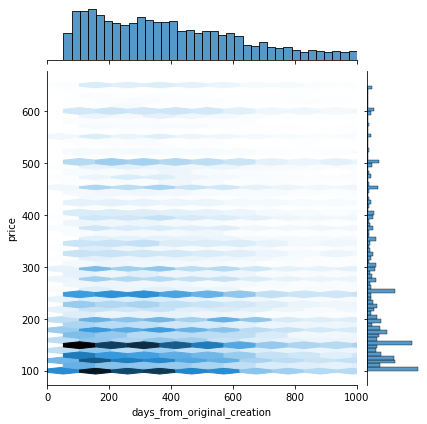

In [172]:
sns.jointplot(x='days_from_original_creation',y='price',data=all_paintings_df,kind='hex',xlim=[0,1000])

Categorical features:
    
4) Dependence of price on the taxonomy (watercolors, oil, etc.)

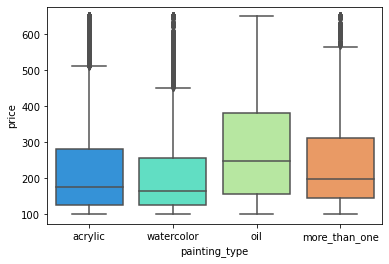

In [342]:
sns.boxplot(x="painting_type", y="price", data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/prices_vs_type_boxplot.png', dpi=300)

5) Dependence of price on when the painting was made (2020's, 2010s, etc)

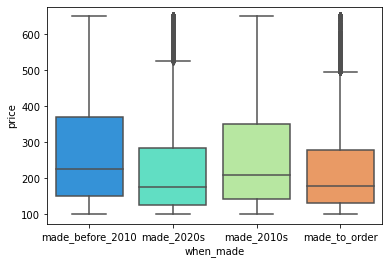

In [343]:
sns.boxplot(x="when_made", y="price", data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/prices_vs_whenmade_boxplot.png', dpi=300)

Boolean features:

6) Painting customizable

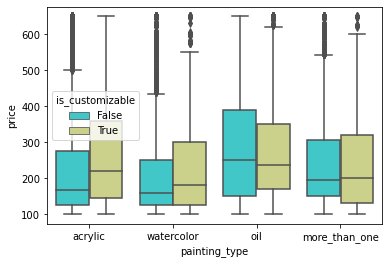

In [344]:
sns.boxplot(x="painting_type", y="price",hue='is_customizable', data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/prices_vs_customizable_by_type.png', dpi=300)

7) Painting has variations

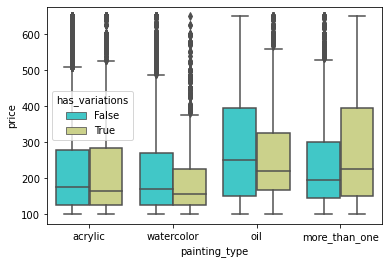

In [345]:
sns.boxplot(x="painting_type", y="price",hue='has_variations', data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/prices_vs_hasvariations.png', dpi=300)

8) Painting made by seller

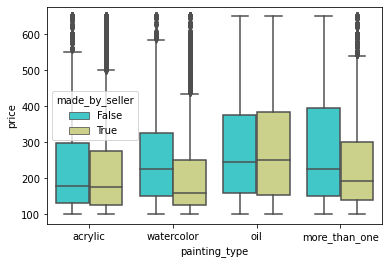

In [346]:
sns.boxplot(x="painting_type", y="price",hue='made_by_seller', data=all_paintings_df,palette='rainbow')
plt.savefig('./Git_exclude/Figures/prices_vs_madebyseller_by_type.png', dpi=300)

In [178]:
#It looks like many of the numerical or categorical features have a mild predictive power on the price of the painting
#I need to quantify more qualitative features, such as the style of the paintings, its colors, etc.

### Preprocessing of tags

In [179]:
#First thing I need to use 'eval' to convert the tag columns from strings representing lists to actual lists of strings

In [180]:
all_paintings_df['materials'] = all_paintings_df['materials'].apply(lambda x:eval(x))

In [181]:
all_paintings_df['tags'] = all_paintings_df['tags'].apply(lambda x:eval(x))

In [182]:
all_paintings_df['style'] = all_paintings_df['style'].apply(lambda x:eval(x))

### Find common tags describing materials 

In [183]:
#Let's check how many entries have materials information

In [184]:
all_paintings_df['num_material_tags']=all_paintings_df['materials'].apply(lambda x:len(x))

In [185]:
#Let's list all the different material tags found in exclusively the 'materials' column and create a dictionary

In [186]:
paintings_with_orig_material_tags_df = all_paintings_df[all_paintings_df['num_material_tags']>0]

In [187]:
len(paintings_with_orig_material_tags_df)

92944

In [188]:
paintings_with_orig_material_tags_df.iloc[0]['materials']

['Canvas board']

In [189]:
paintings_with_orig_material_tags_df['materials'].iloc[13]

['watercolor', 'paper']

In [190]:
#old version: make a list of all possible materials by listing full tags
material_all_list = []
[material_all_list.append(material_tag.lower()) 
 for material_tags in paintings_with_orig_material_tags_df['materials']
 for material_tag in material_tags if material_tag.lower() not in material_all_list];

In [191]:
len(material_all_list)

12427

In [192]:
material_all_list[1000:1100]

['d ring hanger with wire',
 'soft pastel',
 'paintbrushes',
 'natural cotton canvas',
 'mixed media  acrylic on canvas',
 'squirrel mop brush',
 'holbein palette',
 'kneaded eraser',
 'transparent color',
 'semi opaque',
 'shell pink',
 'canvas paper',
 'high quality textured canvas panel',
 'mixed media oil on canvas panel',
 'oil paint on panel',
 'oilpaint',
 'paintbrush',
 'flood',
 'polyester',
 'aluminum',
 'oneshot paint',
 'art and collectables',
 'landscape oil painting',
 'landscape on canvas',
 'california landscape painting',
 'landscape oil painting on canvas',
 'landscape painting',
 'landscape oil art',
 'landscape art',
 'landscape wall decor',
 'fields in landscape painting',
 'lynn fogel art',
 'protective varnish',
 'wire mounted',
 'linen canvas',
 'goauche',
 'natural gourd',
 'half back pearls',
 'collage',
 'sumi brush',
 'sumi ink',
 'squirrel mop brush canson watercolor paper',
 'liquitex ink',
 'hasitomo ink',
 'stillman and birn beta sketchbook',
 'ink pigme

In [193]:
#Problem seems to be that not only materials info, but some other info (sometimes about subject, sometimes about style, also sneaked here)
#Let's see in how many different paintings each of these material tags appeared... it's then likely that if we keep only the most common tags those will
#for sure be material-related tags

In [194]:
#new version: use a vectorizer that separates the words and keeps only those that occur in a min number of entries
from sklearn.feature_extraction.text import CountVectorizer

#exclude words that I know are not specific to materials
materials_stopwords=['art','artwork','painting','paintings','paint','paints','illustration','drawing','color','colors','colored',\
                       'and','on','of','for','to','in','the','a','an','with','by','large','small','medium','gift',\
                       'artist','professional','original','quality','custom','ready','artists',\
                        'handmade','signed','gallery','wall','decor','free','high','no','colorful',\
                        'landscape','portrait','abstract','contemporary','impressionism','expressionism','realism','vintage']

In [195]:
#I am going to keep only the 100 most common material tags as separate features
materials_tokenizer = CountVectorizer(min_df=50,max_df=0.8,stop_words=materials_stopwords,max_features=100)

In [196]:
#First, I need to join all listed materials for a given listing into a single string for tokenization

paintings_with_orig_material_tags_df['materials'].apply(lambda x:' '.join(x))


0                       Canvas board
1                       Canvas board
2                       Canvas board
3         acrylics panel ink markers
4                       Canvas board
                     ...            
119576              Wood & hardboard
119577              Stretched canvas
119578              Stretched canvas
119580                  Canvas board
119582              Stretched canvas
Name: materials, Length: 92944, dtype: object

In [197]:
tokenized_material_tags = materials_tokenizer.fit_transform(paintings_with_orig_material_tags_df['materials'].apply(lambda x:' '.join(x)))

In [198]:
tokenized_material_tags

<92944x100 sparse matrix of type '<class 'numpy.int64'>'
	with 218524 stored elements in Compressed Sparse Row format>

In [199]:
material_tags_list = materials_tokenizer.get_feature_names()

In [200]:
material_tags_list[:10]

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue']

In [201]:
#check the count of words:

count_list = np.asarray(tokenized_material_tags.sum(axis=0))

In [202]:
token_counts = dict(zip(material_tags_list,count_list[0]))

In [203]:
token_counts_sorted = dict(sorted(token_counts.items(), key=lambda item: item[1],reverse=True))

In [204]:
token_counts_sorted

{'canvas': 60904,
 'stretched': 33642,
 'paper': 19440,
 'acrylic': 18589,
 'oil': 14101,
 'wood': 10201,
 'watercolor': 8241,
 'board': 8220,
 'hardboard': 5621,
 'frame': 3131,
 'varnish': 3088,
 'ink': 2610,
 'panel': 2008,
 'brush': 1116,
 'knife': 1094,
 'palette': 1047,
 'archival': 1041,
 'brushes': 992,
 'pencil': 980,
 'resin': 946,
 'wrapped': 920,
 'glass': 877,
 'acrylics': 865,
 'gold': 819,
 'media': 810,
 'arches': 795,
 'grade': 772,
 'mixed': 749,
 'cotton': 703,
 'watercolors': 690,
 'gloss': 682,
 'pen': 676,
 'metal': 639,
 'white': 634,
 'water': 632,
 'black': 631,
 'gesso': 622,
 'love': 603,
 'cold': 582,
 'wire': 569,
 'wooden': 546,
 'glitter': 538,
 'acid': 522,
 'cardboard': 502,
 'leaf': 493,
 'gouache': 481,
 'newton': 470,
 'hand': 468,
 'framed': 453,
 'oils': 451,
 'spray': 437,
 'texture': 422,
 'hanging': 420,
 'blue': 412,
 'linen': 409,
 'mat': 398,
 'hang': 397,
 'pastel': 390,
 'matte': 378,
 'clear': 377,
 'winsor': 377,
 'fabric': 363,
 'painted

In [205]:
#I want to keep only the 100 most common material tags in the 'materials' specific 'tag', and move all the remaining keywords to the
#general 'tags'. Conversely, if I find one of these 'material'-specific tags in the general 'tags' or the 'style' tags list, I want to move
#those in the 'materials' section.

In [206]:
material_tags_list

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

### Find common tags describing style 

In [207]:
#Let's check how many entries have style information

In [208]:
all_paintings_df['num_style_tags']=all_paintings_df['style'].apply(lambda x:len(x))

In [209]:
#Let's list all the different style tags found in exclusively the 'style' column and create a dictionary

In [210]:
paintings_with_orig_style_tags_df = all_paintings_df[all_paintings_df['num_style_tags']>0]

In [211]:
len(paintings_with_orig_style_tags_df)

7600

In [212]:
paintings_with_orig_style_tags_df.iloc[0]['style']

['Abstract', 'Modern']

In [213]:
paintings_with_orig_style_tags_df['style'].iloc[13]

['Minimalist', 'Art Deco']

In [214]:
#old version: make a list of all possible styles by listing full tags
style_all_list = []
[style_all_list.append(style_tag.lower()) 
 for style_tags in paintings_with_orig_style_tags_df['style']
 for style_tag in style_tags if style_tag.lower() not in style_all_list];


In [215]:
style_all_list

['abstract',
 'modern',
 'fantasy',
 'beach',
 'boho',
 'minimalist',
 'southwestern',
 'woodland',
 'traditional',
 'zen',
 'asian',
 'cottage chic',
 'art deco',
 'high fashion',
 'hippie',
 'realistimpressionist',
 'mid century',
 'primitive',
 'art nouveau',
 'mod',
 'folk',
 'rustic',
 'industrial',
 'resort',
 'hipster',
 'country western',
 'rocker',
 'hip hop',
 'avant garde',
 'sci fi',
 'retro',
 'historical',
 'steampunk',
 'goth',
 'horror',
 'tribal',
 'spooky',
 'athletic',
 'baseball memorabilia',
 'sports art and illustration',
 'mediterranean',
 'floral',
 'whimsical art',
 'contemporary',
 'kawaii',
 'kitsch',
 'shabby chic',
 'edwardian',
 'african',
 'impressionist',
 'landscape oil painting',
 'nautical',
 'realism',
 'burlesque',
 'seascape marine',
 'americana southwestern native american style',
 'impressionist impressionism landscape miniatu',
 'renaissance',
 'techie',
 'victorian',
 'whimsical',
 'impressionism',
 'неоклассический',
 'традиционный',
 'america

In [216]:
#the list above shows that there are a few problems:
#'style' tags seem to also include non-stlye tags such as the subject, etc.
#words like 'impressionist', 'impressionistic', 'impressionism' are currently separated (and similarly, american-americana)


In [217]:
#So first of all, I replace all suffixes 'ist' and 'istic' with 'ism' so that words like 'impressionist', 'impressionistic', 'impressionism' are
#not considered different styles

import re

def consolidate_suffix(tags):
    tags_joined = ' '.join(tags).lower()
    tags_joined = re.sub(r'\b([a-z]*)istic\b',lambda m:m.group(1)+'ism', tags_joined) 
    tags_joined = re.sub(r'\b([a-z]*)ist\b',lambda m:m.group(1)+'ism', tags_joined)
    tags_joined = re.sub(r'\b([a-z]*)ana\b',lambda m:m.group(1)+'an', tags_joined)
    return tags_joined

In [218]:
consolidate_suffix(['expressionist','expressionism','expressionistic','americana'])

'expressionism expressionism expressionism american'

In [219]:
paintings_with_orig_style_tags_df.iloc[338:350]['style']

11328                             [Abstract, Minimalist]
11337                                          [Fantasy]
11480                                          [Fantasy]
11486                                   [Abstract, Boho]
11497     [Americana Southwestern Native American Style]
11508                            [Traditional, Art Deco]
11568    [Impressionist Impressionism Landscape Miniatu]
11576                       [Traditional, impressionist]
11654                                           [Modern]
11877                                          [Fantasy]
12165                                 [Abstract, Modern]
12166                         [Renaissance, Traditional]
Name: style, dtype: object

In [220]:
paintings_with_orig_style_tags_df['style'].apply(lambda x:consolidate_suffix(x)).iloc[338:350]

11328                              abstract minimalism
11337                                          fantasy
11480                                          fantasy
11486                                    abstract boho
11497      american southwestern native american style
11508                             traditional art deco
11568    impressionism impressionism landscape miniatu
11576                        traditional impressionism
11654                                           modern
11877                                          fantasy
12165                                  abstract modern
12166                          renaissance traditional
Name: style, dtype: object

In [221]:
#new version: use a vectorizer that separates the words and keeps only those that occur in a min number of entries
from sklearn.feature_extraction.text import CountVectorizer

#exclude words that I know are not specific to materials
style_stopwords=['art','artwork','painting','paintings','paint','paints','illustration','drawing','color','colors','colored',\
                       'and','on','of','for','to','in','the','a','an','with','by','fi','large','small','medium','gift','mid',\
                       'artist','professional','original','quality','custom','ready','artists','artism',\
                        'handmade','signed','gallery','still','life','high','garde','wall','decor','free','high','no','colorful',\
                        'watercolor','oil','acrylic','canvas','board']

In [222]:
#I am going to keep only the 100 most common style tags as separate features
style_tokenizer = CountVectorizer(min_df=16,max_df=0.8,stop_words=style_stopwords,max_features=100)

In [223]:
tokenized_style_tags = style_tokenizer.fit_transform(paintings_with_orig_style_tags_df['style'].apply(lambda x:consolidate_suffix(x)))

In [224]:
tokenized_style_tags

<7600x69 sparse matrix of type '<class 'numpy.int64'>'
	with 14418 stored elements in Compressed Sparse Row format>

In [225]:
style_tags_list = style_tokenizer.get_feature_names()

In [226]:
style_tags_list[:10]

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque']

In [227]:
#check the count of words:
count_list = np.asarray(tokenized_style_tags.sum(axis=0))

In [228]:
token_counts = dict(zip(style_tags_list,count_list[0]))

In [229]:
token_counts_sorted = dict(sorted(token_counts.items(), key=lambda item: item[1],reverse=True))

In [230]:
token_counts_sorted

{'abstract': 3611,
 'modern': 3134,
 'traditional': 967,
 'deco': 570,
 'fantasy': 428,
 'chic': 398,
 'cottage': 397,
 'woodland': 317,
 'beach': 306,
 'folk': 296,
 'impressionism': 294,
 'nautical': 205,
 'century': 197,
 'boho': 186,
 'southwestern': 182,
 'rustic': 173,
 'zen': 162,
 'retro': 142,
 'minimalism': 127,
 'historical': 109,
 'asian': 106,
 'western': 106,
 'country': 102,
 'realism': 102,
 'african': 98,
 'hipster': 84,
 'landscape': 82,
 'goth': 81,
 'avant': 79,
 'primitive': 77,
 'nouveau': 73,
 'традиционный': 72,
 'expressionism': 71,
 'sci': 70,
 'mediterranean': 68,
 'victorian': 68,
 'resort': 63,
 'american': 62,
 'industrial': 52,
 'rocker': 52,
 'cовременный': 51,
 'spooky': 48,
 'automobilia': 45,
 'fashion': 44,
 'neoclassical': 41,
 'hippie': 38,
 'tribal': 37,
 'renaissance': 35,
 'edwardian': 34,
 'burlesque': 31,
 'photorealism': 31,
 'whimsical': 31,
 'vintage': 30,
 'mod': 29,
 'portrait': 29,
 'regency': 27,
 'steampunk': 26,
 'floral': 25,
 'holly

In [231]:
#check that the style tags list and the materials tags list have no overlap
set(style_tags_list).intersection(material_tags_list)

set()

### Now that I have the common 'material' and 'style' tags, correct the tags as follows for each listing:
#### find any instance of a 'material' tag in either the 'materials', 'style' or general 'tags' for the listing
#### find any instance of a 'style' tag in either the 'materials', 'style' or general 'tags' for the listing
#### any other tag that is not a 'material' or 'style' tag is added to the general 'tags' list


In [232]:
#First I apply the 'consolidate suffix to all tags' in 'all_paintings_df' (not only the style ones but also the material ones and general tags)

In [233]:
all_paintings_df['style'] = all_paintings_df['style'].apply(lambda x:consolidate_suffix(x))

In [234]:
all_paintings_df['materials'] = all_paintings_df['materials'].apply(lambda x:consolidate_suffix(x))

In [235]:
all_paintings_df['tags'] = all_paintings_df['tags'].apply(lambda x:consolidate_suffix(x))

In [236]:
all_paintings_df.iloc[38]['style']

'boho hippie'

In [237]:
all_paintings_df.iloc[38]['tags']

"popular right now koi fish painting original painting trending art canvas art gift for him living room wall art birthday gift nursery decor animal artwork unique gift artwork best selling item editor's picks"

In [238]:
all_paintings_df.iloc[38]['materials']

'canvas board'

In [239]:
all_paintings_df['style'] = all_paintings_df['style'].apply(lambda x:x.split())

In [240]:
all_paintings_df['materials'] = all_paintings_df['materials'].apply(lambda x:x.split())

In [241]:
all_paintings_df['tags'] = all_paintings_df['tags'].apply(lambda x:x.split())

In [242]:
all_paintings_df.iloc[33]['style']

['high', 'fashion', 'modern']

In [243]:
all_paintings_df.iloc[33]['materials']

['stretched', 'canvas']

In [244]:
all_paintings_df.iloc[33]['tags']

['popular',
 'right',
 'now',
 'red',
 'fox',
 'tail',
 'original',
 'painting',
 'animal',
 'artwork',
 'wildlife',
 'painting',
 'best',
 'seller',
 'gift',
 'for',
 'him',
 'kitchen',
 'wall',
 'art',
 'modern',
 'art',
 'birthday',
 'gift',
 'trending',
 'art',
 'nursery',
 'decor',
 'folk',
 'artwork']

In [245]:
def edit_tags(material_style_tags_together):
    material_tags = material_style_tags_together[0]
    material_tags_initial_set = set(material_tags)
    material_tags_set_in_mat = material_tags_initial_set.intersection(set(material_tags_list))
    style_tags_set_in_mat = material_tags_initial_set.intersection(set(style_tags_list))
    other_tags_set_in_mat = material_tags_initial_set.difference(material_tags_set_in_mat.union(style_tags_set_in_mat))
    
    style_tags = material_style_tags_together[1]
    style_tags_initial_set = set(style_tags)
    material_tags_set_in_style = style_tags_initial_set.intersection(set(material_tags_list))
    style_tags_set_in_style = style_tags_initial_set.intersection(set(style_tags_list))
    other_tags_set_in_style = style_tags_initial_set.difference(material_tags_set_in_style.union(style_tags_set_in_style))
    
    tags = material_style_tags_together[2]
    general_tags_initial_set = set(tags)
    material_tags_set_in_gen = general_tags_initial_set.intersection(set(material_tags_list))
    style_tags_set_in_gen = general_tags_initial_set.intersection(set(style_tags_list))
    other_tags_set_in_gen = general_tags_initial_set.difference(material_tags_set_in_gen.union(style_tags_set_in_gen))
    
    material_tags_new = list(material_tags_set_in_mat.union(material_tags_set_in_style.union(material_tags_set_in_gen)))
    style_tags_new = list(style_tags_set_in_mat.union(style_tags_set_in_style.union(style_tags_set_in_gen)))
    tags_new = list(other_tags_set_in_mat.union(other_tags_set_in_style.union(other_tags_set_in_gen)))
    
    return material_tags_new, style_tags_new, tags_new

In [246]:
#Here is where I actually edit the tags and produce new versions:

In [247]:
all_paintings_df[['materials_tags_new','style_tags_new','tags_new']]=all_paintings_df[['materials','style','tags']].apply(edit_tags,axis=1,result_type='expand')

In [248]:
all_paintings_df.iloc[33]

listing_id                                                                                                               176961929
user_id                                                                                                                    6392332
shop_id                                                                                                                    5392165
title                          Popular Right Now, Red Fox Tail, Animal Artwork, Original Painting, Wildlife Painting,Gift for H...
description                    Popular Right Now, Red Fox Tail, Original Painting, Minimalist Art, Animal Artwork, Wildlife Pai...
shop_section_id                                                                                                         18130050.0
featured_rank                                                                                                                   -1
url                                                   https://www.etsy.com/listing/

In [249]:
#remember that originally I had the following number of listings with some materials information:
len(paintings_with_orig_material_tags_df)

92944

In [250]:
#Let's see how many I have now:
all_paintings_df['num_material_tags_new']=all_paintings_df['materials_tags_new'].apply(lambda x:len(x))

In [251]:
len(all_paintings_df[all_paintings_df['num_material_tags_new']>0])

105326

In [252]:
#similarly, I had the following number of listings with style information:
len(paintings_with_orig_style_tags_df)

7600

In [253]:
#Let's see how many I have now:
all_paintings_df['num_style_tags_new']=all_paintings_df['style_tags_new'].apply(lambda x:len(x))

In [254]:
len(all_paintings_df[all_paintings_df['num_style_tags_new']>0])

70659

In [255]:
#How many listings have both style tags and material tags of the new kind?
len(all_paintings_df.query('num_style_tags_new>0 and num_material_tags_new>0'))

68554

In [256]:
#Let's create a new dataframe with all the entries that have these new style tags
paintings_with_new_style_tags_df = all_paintings_df[all_paintings_df['num_style_tags_new']>0]

In [257]:
len(paintings_with_new_style_tags_df)

70659

In [258]:
#Let's also throw the entries that don't have material tags
paintings_with_new_style_tags_df = paintings_with_new_style_tags_df[paintings_with_new_style_tags_df['num_material_tags_new']>0]

In [259]:
len(paintings_with_new_style_tags_df)

68554

In [260]:
paintings_with_new_style_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68554 entries, 0 to 119582
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   68554 non-null  int64  
 1   user_id                      68554 non-null  int64  
 2   shop_id                      68554 non-null  int64  
 3   title                        68553 non-null  object 
 4   description                  68554 non-null  object 
 5   shop_section_id              47075 non-null  float64
 6   featured_rank                68554 non-null  int64  
 7   url                          68554 non-null  object 
 8   num_favorers                 68554 non-null  int64  
 9   is_customizable              68554 non-null  bool   
 10  tags                         68554 non-null  object 
 11  materials                    68554 non-null  object 
 12  shipping_profile_id          49945 non-null  float64
 13  when_made      

In [261]:
#remove the variables that are not needed anymore
paintings_with_new_style_tags_df.drop(['num_style_tags','num_style_tags_new','num_material_tags','num_material_tags_new',\
                                      'style','materials','tags'],axis=1,inplace=True)

In [262]:
paintings_with_new_style_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68554 entries, 0 to 119582
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   68554 non-null  int64  
 1   user_id                      68554 non-null  int64  
 2   shop_id                      68554 non-null  int64  
 3   title                        68553 non-null  object 
 4   description                  68554 non-null  object 
 5   shop_section_id              47075 non-null  float64
 6   featured_rank                68554 non-null  int64  
 7   url                          68554 non-null  object 
 8   num_favorers                 68554 non-null  int64  
 9   is_customizable              68554 non-null  bool   
 10  shipping_profile_id          49945 non-null  float64
 11  when_made                    68554 non-null  object 
 12  has_variations               68554 non-null  bool   
 13  price          

### Save (if it doesn't already exist) the subset of paintings that have style tags into a new file for further processing

In [263]:

#Note: 'min_price' was defined above (100.0, or 250.0 if looking at the reduced subset of paintings)

csv_combined_filename_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'

#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    paintings_with_new_style_tags_df = pd.read_csv(csv_combined_filename_w_style)

    print(f'Loaded all listings file {csv_combined_filename_w_style} with some style-related tags, after cleaning up the data.')

except FileNotFoundError:

    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    paintings_with_new_style_tags_df.to_csv(csv_combined_filename_w_style,index=False)
    print(f'Saved all listings file {csv_combined_filename_w_style} with some style-related tags, after cleaning up the data.')
    

Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD100_listings_with_style_tags.csv with some style-related tags, after cleaning up the data.


In [ ]:
STOP HERE - THIS IS TO PREVENT THE DOWNLOAD OF IMAGE INFO TO START AUTOMATICALLY WHEN I RUN THE WHOLE SCRIPT

# PART 4: Download Listing IMAGE information (urls of jpeg images, mean colors, etc.) - but not yet the images themselves - at least for the listings with style tags 

### Investigate information available about the images associated to a listing

In [264]:
len(paintings_with_new_style_tags_df)

68554

In [265]:
#What I am interested though are the methods to get the listing image or images associated with a painting: getListingImage or get ListingImages
#e.g. to get the images associated with the first painting above:

paintings_with_new_style_tags_df.iloc[0]['shop_id']

5342448

In [266]:
#url of the listing
paintings_with_new_style_tags_df.iloc[0]['url']

'https://www.etsy.com/listing/18131517/original-painting6x6-yellow-red-abstract'

In [267]:
url_listing_images = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images'.format(shop_id=paintings_with_new_style_tags_df.iloc[0]['shop_id'],listing_id=paintings_with_new_style_tags_df.iloc[0]['listing_id'])
url_listing_images

'https://openapi.etsy.com/v3/application/shops/5342448/listings/18131517/images'

In [268]:
response_listing_images = requests.get(url_listing_images, headers = headers)
response_listing_images_data = response_listing_images.json() 

In [269]:
response_listing_images_data

{'count': 5,
 'results': [{'listing_id': 18131517,
   'listing_image_id': 533484667,
   'hex_code': 'A46A3F',
   'red': 164,
   'green': 106,
   'blue': 63,
   'hue': 26,
   'saturation': 61,
   'brightness': 64,
   'is_black_and_white': False,
   'creation_tsz': 1385774114,
   'rank': 1,
   'url_75x75': 'https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg',
   'url_170x135': 'https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg',
   'url_570xN': 'https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg',
   'url_fullxfull': 'https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg',
   'full_height': 597,
   'full_width': 600},
  {'listing_id': 18131517,
   'listing_image_id': 533484487,
   'hex_code': 'A56A3A',
   'red': 165,
   'green': 106,
   'blue': 58,
   'hue': 27,
   'saturation': 64,
   'brightness': 64,
   'is_black_and_white': False,
   'creation_tsz': 1385

In [270]:
sample_listing_all_images_df =  pd.DataFrame(response_listing_images_data['results'])
sample_listing_all_images_df

,listing_id,listing_image_id,hex_code,red,green,blue,hue,saturation,brightness,is_black_and_white,creation_tsz,rank,url_75x75,url_170x135,url_570xN,url_fullxfull,full_height,full_width
0,18131517,533484667,A46A3F,164,106,63,26,61,64,False,1385774114,1,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg,597,600
1,18131517,533484487,A56A3A,165,106,58,27,64,64,False,1385774114,2,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_75x75.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_170x135.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_570xN.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_fullxfull.533484487_ou4b.jpg,596,600
2,18131517,533484805,955B46,149,91,70,16,53,58,False,1385774114,3,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_75x75.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_170x135.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_570xN.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_fullxfull.533484805_2m2k.jpg,621,570
3,18131517,533398608,AB7339,171,115,57,31,66,67,False,1385774114,4,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_75x75.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_170x135.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_570xN.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_fullxfull.533398608_koe5.jpg,533,600
4,18131517,796844864,000000,0,0,0,0,0,0,None,1435977240,5,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_75x75.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_170x135.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_570xN.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_fullxfull.796844864_ecvy.jpg,576,570


In [271]:
#Let's download for example the 570xN version of the image
url_listing_sample_image_570N = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images/{listing_image_id}'.format(shop_id=paintings_with_new_style_tags_df.iloc[0]['shop_id'],
                                                        listing_id=paintings_with_new_style_tags_df.iloc[0]['listing_id'], listing_image_id=sample_listing_all_images_df['listing_image_id'].iloc[0])
url_listing_sample_image_570N



'https://openapi.etsy.com/v3/application/shops/5342448/listings/18131517/images/533484667'

### Here is the actual loop requesting, organizing and saving all image information for each the listings which has at least some style tags  

In [272]:
from ediblepickle import checkpoint
import os
from urllib.parse import quote

cache_dir = './Git_exclude/cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [273]:
import time

In [274]:
from retrying import retry

In [275]:
#This is the main workhorse function to get image data from 1 listing at a time, transform to dataframe and 
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attempts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: 'listing'+ str(args[1]) + '_image_data.pkl', work_dir=cache_dir)
def get_image_info_single_listing(shop_id,listing_id):
    
    url_listing_images = f'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images'
    
    response_listing_images = requests.get(url_listing_images, headers = headers)
    response_listing_images_data = response_listing_images.json() 

    response_listing_images_df =  pd.DataFrame(response_listing_images_data['results'])
    return response_listing_images_df

In [276]:
paintings_with_new_style_tags_df.iloc[0]

listing_id                                                                                                                18131517
user_id                                                                                                                    6081676
shop_id                                                                                                                    5342448
title                          ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...
description                    ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...
shop_section_id                                                                                                          5865531.0
featured_rank                                                                                                                   -1
url                                                 https://www.etsy.com/listing/18

In [277]:
temp_shops =[]
temp_listings = []
for shop_id,listing_id in paintings_with_new_style_tags_df[['shop_id','listing_id']].values:
    temp_shops.append(shop_id)
    temp_listings.append(listing_id)
    
    

In [278]:
temp_shops[10]

5889085

In [279]:
temp_listings[10]

66775761

In [280]:
paintings_with_new_style_tags_df.iloc[10]

listing_id                                                                                                                66775761
user_id                                                                                                                    9977031
shop_id                                                                                                                    5889085
title                                                                            Valle Vidal Cliffs - Original Watercolor Painting
description                    Cliffs in Northern New Mexico at Valle Vidal.\n\nOriginal watercolor on paper,12&quot; x 16&quot...
shop_section_id                                                                                                         21895063.0
featured_rank                                                                                                                   -1
url                                                   https://www.etsy.com/listing/

#### Here is the actual iteration that reads and stores image info (10000 listings at a time)

In [291]:
#Iterate over all listings in the 'paintings_with_new_style_tags_df' dataframe, and create a new dataframe with the image info for 10000 paintings at a time 
#(note that there is a daily limit of Etsy API requests, which is around 10000, so it's better to save intermediate steps to prevent losing data if something goes wrong)
#It also helps to have reasonable sizes of the .csv (e.g. for future use in a SQL database) 

#Note: 'min_price' was defined above (100.0, or 250.0 if looking at the reduced subset of paintings)

import numpy as np

csv_filename_all_image_info_paintings_w_style = f'./Git_exclude/Data/image_info_all_listings_from_USD{int(min_price)}_with_style_tags.csv'

#I want to break the listings into chunks of at most 10000 entries each (because requests after that tend to be rejected)

num_listings = paintings_with_new_style_tags_df['listing_id'].nunique()

#starting offsets for each chunk:
starting_offsets = range(0,num_listings,10000)

for i,starting_offset in enumerate(starting_offsets):

    if i>0:
        next_csv_filename = csv_filename_all_image_info_paintings_w_style[:-4]+f'_{i}.csv'
    else:
        next_csv_filename = csv_filename_all_image_info_paintings_w_style

    #If the file with the listing data already exists for this taxonomy id, I load it:
    try:
        image_info_all_paintings_with_new_style_tags_df = pd.read_csv(next_csv_filename)

        #if I reached here and this is not the last call, find the last listing_id that was included in the file (useful for the next iterations)
        if i<(len(starting_offsets)-1):
            
            last_listing_id = image_info_all_paintings_with_new_style_tags_df.iloc[-1]['listing_id']
            last_listing_price = paintings_with_new_style_tags_df[paintings_with_new_style_tags_df['listing_id']==last_listing_id]['price'].values[0]
        
            print(f'Loaded image data file {next_csv_filename} for listings with style tags up to listing {last_listing_id} having price {last_listing_price}.')
            
        else: #if it's the last file:
            last_listing_price = paintings_with_new_style_tags_df.iloc[-1]['price']
            print(f'Loaded image data file {next_csv_filename} for listings with style tags up to price {last_listing_price}.')

    except FileNotFoundError:

        if i==0:
            index_of_first_listing_to_consider = 0
        else:
            index_of_first_listing_to_consider = np.where(paintings_with_new_style_tags_df['listing_id'].values==last_listing_id)[0][0]+1
         
        if i<(len(starting_offsets)-1):
            index_of_last_listing_to_consider = index_of_first_listing_to_consider + 9999
        else:
            index_of_last_listing_to_consider = len(paintings_with_new_style_tags_df) - 1
            
        
        try: #if there is a version of 'image_info_all_paintings_with_new_style_tags_df' around, I delete it
            del image_info_all_paintings_with_new_style_tags_df
        except NameError:
            pass

        for shop_id,listing_id in paintings_with_new_style_tags_df[['shop_id','listing_id']].values[index_of_first_listing_to_consider:(index_of_last_listing_to_consider+1)]:

            try: #note that 'get_image_info_single_listing' already tries 100 times, but here I want to catch 
                 #the exeption of more than 100 failed attempts (e.g. if there is no valid image info for a particular listing)
                single_listing_all_image_info_df = get_image_info_single_listing(shop_id,listing_id)
            except Exception as single_listing_exception:
                print(f'Exception encountered requesting image info for listing {listing_id}:')
                print(single_listing_exception)
                continue #move to the next listing

            try:
                image_info_all_paintings_with_new_style_tags_df = pd.concat([image_info_all_paintings_with_new_style_tags_df, single_listing_all_image_info_df])

            except NameError: #if it's the first listing, I start the dataframe that will eventually contain info for all listings
                image_info_all_paintings_with_new_style_tags_df = single_listing_all_image_info_df

            time.sleep(1)

        #save to .csv file
        image_info_all_paintings_with_new_style_tags_df.to_csv(next_csv_filename,index=False)
        
        #if I reached here and this is not the last call, find the last listing_id that was included in the file (useful for the next iterations)
        if i<(len(starting_offsets)-1):
            
            last_listing_id = image_info_all_paintings_with_new_style_tags_df.iloc[-1]['listing_id']
            last_listing_price = paintings_with_new_style_tags_df[paintings_with_new_style_tags_df['listing_id']==last_listing_id]['price'].values[0]
        
            print(f'Saved image data file {next_csv_filename} for listings with style tags up to listing {last_listing_id} having price {last_listing_price}.')
            
        else: #if it's the last file:
            last_listing_price = paintings_with_new_style_tags_df.iloc[-1]['price']
            print(f'Saved image data file {next_csv_filename} for listings with style tags up to price {last_listing_price}.')
    

Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags.csv for listings with style tags up to listing 775857387 having price 120.0.
Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_1.csv for listings with style tags up to listing 561058892 having price 150.0.
Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_2.csv for listings with style tags up to listing 937615562 having price 175.0.
Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_3.csv for listings with style tags up to listing 923271936 having price 235.0.
Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_4.csv for listings with style tags up to listing 1037781383 having price 300.0.
Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_5.csv for listings with style tags up to l

In [292]:
#Here I need to recombine the image info for all listings into a unique 
#'image_info_all_paintings_with_new_style_tags_df' with data from all listings in 'paintings_with_new_style_tags_df'
# (or at least those for which the request of image info went through)

In [293]:
import glob

#Note: 'min_price' was defined above (100.0, or 250.0 if looking at the reduced subset of paintings)

csv_filename_all_image_info_paintings_w_style_combined = f'./Git_exclude/Data/image_info_all_listings_from_USD{int(min_price)}_with_style_tags_combined.csv'
    
#If the file with all the combined cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    image_info_all_paintings_with_new_style_tags_df = pd.read_csv(csv_filename_all_image_info_paintings_w_style_combined)
    
    print(f'Loaded file {csv_filename_all_image_info_paintings_w_style_combined} with image data for ALL listings with style tags.')

except FileNotFoundError:
    
    try: #it by any chance there is a version of 'image_info_all_paintings_with_new_style_tags_df' around, I delete it
        del image_info_all_paintings_with_new_style_tags_df
    except NameError:
        pass

    csv_filename_pattern_image_data = f'./Git_exclude/Data/image_info_all_listings_from_USD{int(min_price)}_with_style_tags*.csv'

    image_data_csv_files = glob.glob(csv_filename_pattern_image_data)

    for csv_file in image_data_csv_files:

        image_info_df_temp = pd.read_csv(csv_file)

        try: #concatenate to the other
            image_info_all_paintings_with_new_style_tags_df = pd.concat([image_info_all_paintings_with_new_style_tags_df, image_info_df_temp])
        except NameError: #if it's the first iteration, I need to create the dataframe where the data of all paintings will be stored
            image_info_all_paintings_with_new_style_tags_df = image_info_df_temp

    #finally save to .csv file for further processing
    image_info_all_paintings_with_new_style_tags_df.to_csv(csv_filename_all_image_info_paintings_w_style_combined,index=False)
    print(f'Saved file {csv_filename_all_image_info_paintings_w_style_combined} with image data for ALL listings with style tags.')
    


Saved file ./Git_exclude/Data/image_info_all_listings_from_USD100_with_style_tags_combined.csv with image data for ALL listings with style tags.


In [294]:
#total number of images
len(image_info_all_paintings_with_new_style_tags_df)

438280

In [299]:
#total number of listings to which the images refer to:
image_info_all_paintings_with_new_style_tags_df['listing_id'].nunique()

68554

In [300]:
image_info_all_paintings_with_new_style_tags_df.head(10)

,listing_id,listing_image_id,hex_code,red,green,blue,hue,saturation,brightness,is_black_and_white,creation_tsz,rank,url_75x75,url_170x135,url_570xN,url_fullxfull,full_height,full_width
0,18131517,533484667,A46A3F,164.0,106.0,63.0,26.0,61.0,64.0,False,1385774114,1,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg,597,600
1,18131517,533484487,A56A3A,165.0,106.0,58.0,27.0,64.0,64.0,False,1385774114,2,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_75x75.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_170x135.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_570xN.533484487_ou4b.jpg,https://i.etsystatic.com/5342448/r/il/72aacc/533484487/il_fullxfull.533484487_ou4b.jpg,596,600
2,18131517,533484805,955B46,149.0,91.0,70.0,16.0,53.0,58.0,False,1385774114,3,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_75x75.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_170x135.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_570xN.533484805_2m2k.jpg,https://i.etsystatic.com/5342448/r/il/972066/533484805/il_fullxfull.533484805_2m2k.jpg,621,570
3,18131517,533398608,AB7339,171.0,115.0,57.0,31.0,66.0,67.0,False,1385774114,4,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_75x75.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_170x135.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_570xN.533398608_koe5.jpg,https://i.etsystatic.com/5342448/r/il/5da829/533398608/il_fullxfull.533398608_koe5.jpg,533,600
4,18131517,796844864,000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1435977240,5,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_75x75.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_170x135.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_570xN.796844864_ecvy.jpg,https://i.etsystatic.com/5342448/r/il/9d2508/796844864/il_fullxfull.796844864_ecvy.jpg,576,570
5,18796349,55805165,7F1C29,127.0,28.0,41.0,352.0,77.0,49.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_75x75.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_170x135.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_570xN.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_fullxfull.55805165.jpg,597,600
6,18796349,55805196,6C1631,108.0,22.0,49.0,341.0,78.0,42.0,False,1299877281,2,https://i.etsystatic.com/5342448/r/il/963177/55805196/il_75x75.55805196.jpg,https://i.etsystatic.com/5342448/r/il/963177/55805196/il_170x135.55805196.jpg,https://i.etsystatic.com/5342448/r/il/963177/55805196/il_570xN.55805196.jpg,https://i.etsystatic.com/5342448/r/il/963177/55805196/il_fullxfull.55805196.jpg,600,522
7,18796349,55805323,931E21,147.0,30.0,33.0,358.0,79.0,57.0,False,1299877281,3,https://i.etsystatic.com/5342448/r/il/33c6a6/55805323/il_75x75.55805323.jpg,https://i.etsystatic.com/5342448/r/il/33c6a6/55805323/il_170x135.55805323.jpg,https://i.etsystatic.com/5342448/r/il/33c6a6/55805323/il_570xN.55805323.jpg,https://i.etsystatic.com/5342448/r/il/33c6a6/55805323/il_fullxfull.55805323.jpg,600,521
8,18796349,55805370,8F1D21,143.0,29.0,33.0,358.0,79.0,56.0,False,1299877281,4,https://i.etsystatic.com/5342448/r/il/8456ca/55805370/il_75x75.55805370.jpg,https://i.etsystatic.com/5342448/r/il/8456ca/55805370/il_170x135.55805370.jpg,https://i.etsystatic.com/5342448/r/il/8456ca/55805370/il_570xN.55805370.jpg,https://i.etsystatic.com/5342448/r/il/8456ca/55805370/il_fullxfull.55805370.jpg,600,534
9,18796349,796602957,000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1435975461,5,https://i.etsystatic.com/5342448/r/il/298394/796

In [301]:
image_info_all_paintings_with_new_style_tags_df.tail(10)

,listing_id,listing_image_id,hex_code,red,green,blue,hue,saturation,brightness,is_black_and_white,creation_tsz,rank,url_75x75,url_170x135,url_570xN,url_fullxfull,full_height,full_width
88594,562266945,1534815502,847C74,132.0,124.0,116.0,30.0,12.0,51.0,False,1529506808,6,https://i.etsystatic.com/16129260/r/il/f817fc/1534815502/il_75x75.1534815502_j7i7.jpg,https://i.etsystatic.com/16129260/r/il/f817fc/1534815502/il_170x135.1534815502_j7i7.jpg,https://i.etsystatic.com/16129260/r/il/f817fc/1534815502/il_570xN.1534815502_j7i7.jpg,https://i.etsystatic.com/16129260/r/il/f817fc/1534815502/il_fullxfull.1534815502_j7i7.jpg,387,416
88595,562266945,1534816078,6F5F49,111.0,95.0,73.0,35.0,34.0,43.0,False,1529506808,7,https://i.etsystatic.com/16129260/r/il/a8b6e9/1534816078/il_75x75.1534816078_kvo2.jpg,https://i.etsystatic.com/16129260/r/il/a8b6e9/1534816078/il_170x135.1534816078_kvo2.jpg,https://i.etsystatic.com/16129260/r/il/a8b6e9/1534816078/il_570xN.1534816078_kvo2.jpg,https://i.etsystatic.com/16129260/r/il/a8b6e9/1534816078/il_fullxfull.1534816078_kvo2.jpg,2276,2668
88596,562266945,1534815376,8C815E,140.0,129.0,94.0,46.0,32.0,54.0,False,1529506808,8,https://i.etsystatic.com/16129260/r/il/395555/1534815376/il_75x75.1534815376_1gqt.jpg,https://i.etsystatic.com/16129260/r/il/395555/1534815376/il_170x135.1534815376_1gqt.jpg,https://i.etsystatic.com/16129260/r/il/395555/1534815376/il_570xN.1534815376_1gqt.jpg,https://i.etsystatic.com/16129260/r/il/395555/1534815376/il_fullxfull.1534815376_1gqt.jpg,307,444
88597,562266945,1582281325,776D58,119.0,109.0,88.0,41.0,26.0,46.0,False,1529506808,9,https://i.etsystatic.com/16129260/r/il/cce3af/1582281325/il_75x75.1582281325_ds7z.jpg,https://i.etsystatic.com/16129260/r/il/cce3af/1582281325/il_170x135.1582281325_ds7z.jpg,https://i.etsystatic.com/16129260/r/il/cce3af/1582281325/il_570xN.1582281325_ds7z.jpg,https://i.etsystatic.com/16129260/r/il/cce3af/1582281325/il_fullxfull.1582281325_ds7z.jpg,2422,2668
88598,562266945,1570908004,A3978C,163.0,151.0,140.0,29.0,14.0,63.0,False,1532611631,10,https://i.etsystatic.com/16129260/r/il/ef62fd/1570908004/il_75x75.1570908004_9gs3.jpg,https://i.etsystatic.com/16129260/r/il/ef62fd/1570908004/il_170x135.1570908004_9gs3.jpg,https://i.etsystatic.com/16129260/r/il/ef62fd/1570908004/il_570xN.1570908004_9gs3.jpg,https://i.etsystatic.com/16129260/r/il/ef62fd/1570908004/il_fullxfull.1570908004_9gs3.jpg,367,411
88599,562519508,1367803970,B78164,183.0,129.0,100.0,21.0,45.0,71.0,False,1512073653,1,https://i.etsystatic.com/5221720/r/il/58667f/1367803970/il_75x75.1367803970_sf2p.jpg,https://i.etsystatic.com/5221720/r/il/58667f/1367803970/il_170x135.1367803970_sf2p.jpg,https://i.etsystatic.com/5221720/r/il/58667f/1367803970/il_570xN.1367803970_sf2p.jpg,https://i.etsystatic.com/5221720/r/il/58667f/1367803970/il_fullxfull.1367803970_sf2p.jpg,2000,2000
88600,562519508,1367804026,A86946,168.0,105.0,70.0,21.0,58.0,65.0,False,1512073656,2,https://i.etsystatic.com/5221720/r/il/44b47d/1367804026/il_75x75.1367804026_hcd1.jpg,https://i.etsystatic.com/5221720/r/il/44b47d/1367804026/il_170x135.1367804026_hcd1.jpg,https://i.etsystatic.com/5221720/r/il/44b47d/1367804026/il_570xN.1367804026_hcd1.jpg,https://i.etsystatic.com/5221720/r/il/44b47d/1367804026/il_fullxfull.1367804026_hcd1.jpg,1200,1200
88601,562519508,1415074355,693F33,105.0,63.0,51.0,13.0,51.0,41.0,False,1512073649,3,https://i.etsystatic.com/5221720/r/il/915a96/1415074355/il_75x75.1415074355_d3iq.jpg,https://i.etsystatic.com/5221720/r/il/915a96/1415074355/il_170x135.1415074355_d3iq.jpg,https://i.etsystatic.com/5221720/r/il/915a96/1415074355/il_570xN.1415074355_d3iq.jpg,https://i.etsystatic.com/5221720/r/il/915a96/1415074355/il_fullxfull.1415074355_d3iq.jpg,1500,1500
88602,562519508,1367803864,976651,151.0,102.0,81.0,18.0,46.0,59.0,False,1512073646,4,https://i.etsystatic.com/5221720/r/il/af3a98/1367803864/il_75x75.1367803864_53hh.jpg,https://i.etsystatic.com/5221720/r/il/af3a98/1367803864/il_170x135.1367803864_53hh.jpg,https://i.etsy

In [302]:
#sanity check that if I group by listing id (or keep only the image info where 'rank=1') I should get the same (or a little smaller if some listings had no image info) 
#number of listings of the original dataframe with all paintings with style tags

In [303]:
first_image_info_all_paintings_with_new_style_tags_df = image_info_all_paintings_with_new_style_tags_df[image_info_all_paintings_with_new_style_tags_df['rank']==1]

In [311]:
#remove possible duplicates from first_image_info_all_paintings_with_new_style_tags_df (there were several)
first_image_info_all_paintings_with_new_style_tags_df.drop_duplicates(subset='listing_id',keep='first',inplace=True)

<ipython-input-311-48df1fa044e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_image_info_all_paintings_with_new_style_tags_df.drop_duplicates(subset='listing_id',keep='first',inplace=True)


In [317]:
if len(first_image_info_all_paintings_with_new_style_tags_df) < (len(paintings_with_new_style_tags_df) - 100):
    error('Missing image information for more than 100 listings. Check exceptions that were thrown during the requests iteration over paintings_with_new_style_tags_df')

In [318]:
len(first_image_info_all_paintings_with_new_style_tags_df)

68554

In [319]:
len(paintings_with_new_style_tags_df)

68554

In [320]:
#check that all the 'first images' (those with rank=1) have reasonable mean colors (not [0 0 0] or [255 255 255]). This can be 
#compactly investigated by verifying that the 'hex_code' is neither 'FFFFFF' nor '000000'.

In [321]:
listings_with_invalid_color_means = first_image_info_all_paintings_with_new_style_tags_df[(first_image_info_all_paintings_with_new_style_tags_df['hex_code']=='FFFFFF') | (first_image_info_all_paintings_with_new_style_tags_df['hex_code']=='000000')]

In [323]:
len(listings_with_invalid_color_means)

1065

In [325]:
#Let's investigate if the images for these listings were corrupt or whether the 'mean_colors' were incorrectly/reported or actually extreme
listings_with_invalid_color_means.head(10)['url_fullxfull']

378    https://i.etsystatic.com/11061129/r/il/e3ccbc/769835162/il_fullxfull.769835162_ducb.jpg
383     https://i.etsystatic.com/5378841/r/il/b30e04/773508191/il_fullxfull.773508191_moo0.jpg
384     https://i.etsystatic.com/5378841/r/il/bf2440/773468968/il_fullxfull.773468968_frp2.jpg
386     https://i.etsystatic.com/5378841/r/il/a0a572/773510147/il_fullxfull.773510147_ecga.jpg
387     https://i.etsystatic.com/5378841/r/il/d8c5c3/773511421/il_fullxfull.773511421_qng2.jpg
398    https://i.etsystatic.com/11134476/r/il/f9d820/805813757/il_fullxfull.805813757_37ac.jpg
408     https://i.etsystatic.com/9472161/r/il/fe6501/776980035/il_fullxfull.776980035_rg0c.jpg
419     https://i.etsystatic.com/6805253/r/il/67d263/780069902/il_fullxfull.780069902_fda5.jpg
422     https://i.etsystatic.com/7065477/r/il/f359ab/792050432/il_fullxfull.792050432_tf1a.jpg
423     https://i.etsystatic.com/8269509/r/il/040b51/791996856/il_fullxfull.791996856_t8ck.jpg
Name: url_fullxfull, dtype: object

In [326]:
# #The images look fine, so there's no need to drop the listings. 
# #If I wanted to, I would do it like this:
# first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['hex_code'] != 'FFFFFF']
# first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['hex_code'] != '000000']

In [327]:
#This is a previous attempt to look into the second and third ranked images for a listing (if they exist) but was not worth in the end (as some had no valid mean colors in any of the images)

# for listing_id in listings_with_invalid_color_means['listing_id']:
#     try: 
#         image_2_hex_code=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==2)]['hex_code']
#         #print(f'found second image for listing {listing_id} with hex-code {image_2_hex_code}')
#         if (image_2_hex_code.values[0] not in ['FFFFFF','000000']):
#             #print(f'using second image for listing {listing_id}')
#             first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id]=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==2)]
#         else:
#             try:
#                 image_3_hex_code=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==3)]['hex_code']
#                 #print(f'found third image for listing {listing_id} with hex-code {image_3_hex_code}')
#                 if (image_3_hex_code.values[0] not in ['FFFFFF','000000']):
#                     first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id]=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==3)]
#                     #print(f'using third image for listing {listing_id}')
#             except NameError:
#                 continue
#     except NameError:
#         continue

### Here is where I join (inner join) the dataframe with image information with the main dataframe with all the listing info (for listings with style tags), and save the extended dataframe.

In [328]:
#Before joining the image-info dataframe, I rename all columns with prefix 'image_' except for listing_id and listing_image_id, so there is no confusion later on

In [329]:
first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df.add_prefix('image_')

In [330]:
first_image_info_all_paintings_with_new_style_tags_df.head()

,image_listing_id,image_listing_image_id,image_hex_code,image_red,image_green,image_blue,image_hue,image_saturation,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,18131517,533484667,A46A3F,164.0,106.0,63.0,26.0,61.0,64.0,False,1385774114,1,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg,597,600
5,18796349,55805165,7F1C29,127.0,28.0,41.0,352.0,77.0,49.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_75x75.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_170x135.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_570xN.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_fullxfull.55805165.jpg,597,600
10,20875694,56728031,656459,101.0,100.0,89.0,55.0,11.0,39.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_75x75.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_170x135.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_570xN.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_fullxfull.56728031.jpg,600,595
15,20875764,56728251,625B7A,98.0,91.0,122.0,255.0,25.0,47.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_75x75.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_170x135.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_570xN.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_fullxfull.56728251.jpg,600,600
20,21020610,2388683922,8C97A3,140.0,151.0,163.0,211.0,14.0,63.0,False,1593552727,1,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_75x75.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_170x135.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_570xN.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_fullxfull.2388683922_g7lg.jpg,1656,2000


In [331]:
first_image_info_all_paintings_with_new_style_tags_df.rename(columns={'image_listing_id': 'listing_id', 'image_listing_image_id': 'listing_image_id'},inplace=True)

In [332]:
first_image_info_all_paintings_with_new_style_tags_df.head()

,listing_id,listing_image_id,image_hex_code,image_red,image_green,image_blue,image_hue,image_saturation,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,18131517,533484667,A46A3F,164.0,106.0,63.0,26.0,61.0,64.0,False,1385774114,1,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg,597,600
5,18796349,55805165,7F1C29,127.0,28.0,41.0,352.0,77.0,49.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_75x75.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_170x135.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_570xN.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_fullxfull.55805165.jpg,597,600
10,20875694,56728031,656459,101.0,100.0,89.0,55.0,11.0,39.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_75x75.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_170x135.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_570xN.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_fullxfull.56728031.jpg,600,595
15,20875764,56728251,625B7A,98.0,91.0,122.0,255.0,25.0,47.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_75x75.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_170x135.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_570xN.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_fullxfull.56728251.jpg,600,600
20,21020610,2388683922,8C97A3,140.0,151.0,163.0,211.0,14.0,63.0,False,1593552727,1,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_75x75.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_170x135.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_570xN.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_fullxfull.2388683922_g7lg.jpg,1656,2000


In [333]:
paintings_with_new_style_tags_and_image_info_df=paintings_with_new_style_tags_df.merge(first_image_info_all_paintings_with_new_style_tags_df,how='inner',on='listing_id')

In [334]:
len(paintings_with_new_style_tags_and_image_info_df)

68554

In [335]:
paintings_with_new_style_tags_and_image_info_df.head()

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,18131517,6081676,5342448,"ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...","ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...",5865531.0,-1,https://www.etsy.com/listing/18131517/original-painting6x6-yellow-red-abstract,651,False,...,64.0,False,1385774114,1,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_75x75.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_170x135.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_570xN.533484667_nmom.jpg,https://i.etsystatic.com/5342448/r/il/70182e/533484667/il_fullxfull.533484667_nmom.jpg,597,600
1,18796349,6081676,5342448,"ORIGINAL Painting, 6&quot;x 6&quot; Red Blue Yellow Abstract Modern Outsider Expressionistic Lov...","ORIGINAL Painting, 6&quot;x 6&quot; Red Blue Yellow Abstract Modern Outsider Expressionistic Lov...",5865531.0,-1,https://www.etsy.com/listing/18796349/original-painting-6x-6-red-blue-yellow,788,False,...,49.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_75x75.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_170x135.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_570xN.55805165.jpg,https://i.etsystatic.com/5342448/r/il/13596f/55805165/il_fullxfull.55805165.jpg,597,600
2,20875694,6081676,5342448,"ORIGINAL Painting, 6&quot;x 6&quot; Green Red Abstract Modern Outsider Art, Acrylic Contemporary...","ORIGINAL Painting, 6&quot;x 6&quot; Green Red Abstract Modern Outsider Art, Acrylic Contemporary...",5865531.0,-1,https://www.etsy.com/listing/20875694/original-painting-6x-6-green-red,698,False,...,39.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_75x75.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_170x135.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_570xN.56728031.jpg,https://i.etsystatic.com/5342448/r/il/15de89/56728031/il_fullxfull.56728031.jpg,600,595
3,20875764,6081676,5342448,"ORIGINAL Painting, 6&quot; x 6&quot; Purple Blue Orange Abstract Modern Outsider Birds w Creatur...","ORIGINAL Painting, 6&quot; x 6&quot; Purple Blue Orange Abstract Modern Outsider Birds w Creatur...",5865531.0,-1,https://www.etsy.com/listing/20875764/original-painting-6-x-6-purple-blue,890,False,...,47.0,False,1299877281,1,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_75x75.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_170x135.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_570xN.56728251.jpg,https://i.etsystatic.com/5342448/r/il/fecbeb/56728251/il_fullxfull.56728251.jpg,600,600
4,21020610,6392332,5392165,"Ocean Painting, Popular Right Now, Fishing Boat, Original Painting, Water Painting, Man Cave, Gi...","Ocean Painting, Popular Right Now, Water Painting,Fishing Boat, Original Painting\n\nThis fishin...",18130058.0,-1,https://www.etsy.com/listing/21020610/ocean-painting-popular-right-now-fishing,335,True,...,63.0,False,1593552727,1,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_75x75.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_170x135.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_570xN.2388683922_g7lg.jpg,https://i.etsystatic.com/5392165/r/il/4c46ed/2388683922/il_fullxfull.2388683922_g7lg.jpg,1656,2000


In [336]:
#Save the extended dataset for use in the machine learning part of the project

In [337]:
#Note: 'min_price' was defined above (100.0, or 250.0 if looking at the reduced subset of paintings)

csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'

#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    paintings_with_new_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)

    print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with some style-related tags and image information, after cleaning up the data.')

except FileNotFoundError:

    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    paintings_with_new_style_tags_and_image_info_df.to_csv(csv_combined_filename_w_style_n_image_info,index=False)
    print(f'Saved all listings file {csv_combined_filename_w_style_n_image_info} with some style-related tags and image information, after cleaning up the data.')

Saved all listings file ./Git_exclude/Data/all_paintings_from_USD100_listings_with_style_and_image_info.csv with some style-related tags and image information, after cleaning up the data.


In [338]:
paintings_with_new_style_tags_and_image_info_df.iloc[0]

listing_id                                                                                                                18131517
user_id                                                                                                                    6081676
shop_id                                                                                                                    5342448
title                          ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...
description                    ORIGINAL Painting,6&quot;x6&quot; Yellow Red Abstract Modern Outsider Expressionistic Contempora...
shop_section_id                                                                                                          5865531.0
featured_rank                                                                                                                   -1
url                                                 https://www.etsy.com/listing/18

## PART 5: Download the images themselves 

### Note: the images are not used in the current version of the App (v1), but will be used in later versions.
### However, I already downloaded all paintings in the range from 250 to 650 USD to start working on the image processing pipeline, and here I show how that code works

In [ ]:
STOP HERE - THIS IS TO PREVENT THE DOWNLOAD OF IMAGES TO START AUTOMATICALLY WHEN I RUN THE WHOLE SCRIPT (AS IMAGES TAKE A LOT OF SPACE AND TIME TO DOWNLOAD)
                                                                                                         

### Download a single listing image

In [25]:
#To avoid repeating requests of the same images multiple times (given the daily limits on requests), I will create pickle files named as follows:
paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_url_fullxfull'].split('/')[-1].replace('.','_') + '.pkl'

'il_fullxfull_1139187801_70dq_jpg.pkl'

In [32]:
import os

#This is the main workhorse function to download image data from 1 listing at a time
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attempts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: str(args[0]).split('/')[-1].replace('.','_') + '.pkl', work_dir=cache_dir)
def download_image(url, pathname):
    """
    Downloads a file given an URL and puts it in the folder `pathname`
    """
    # if path doesn't exist, make that path dir
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    # get the file name
    filename = os.path.join(pathname, url.split("/")[-1])
    # download the body of response by chunk, not immediately
    with requests.get(url, headers = headers, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return filename



In [34]:
#Test the above code out:

images_folder = './Git_exclude/Painting_images/'

download_image(paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_url_fullxfull'],images_folder)


'./Git_exclude/Painting_images/il_fullxfull.1139187801_70dq.jpg'

### Here is the actual loop going through the painting images url and downloading one image at a time

In [35]:
num_images_to_download = len(paintings_with_new_style_tags_and_image_info_df)

In [36]:
num_images_to_download

19459

In [38]:
for i in range(0,num_images_to_download,1):
    try:#note that 'download_image' already tries 100 times, but here I want to catch 
        #the exeption of more than 100 failed attempts (e.g. if there is no valid image for a particular listing)
        download_image(paintings_with_new_style_tags_and_image_info_df.iloc[i]['image_url_fullxfull'],images_folder)
    except Exception as single_image_exception:
        print(f'Exception encountered downloading image for listing {listing_id}:')
        print(single_image_exception)
        continue #move to the next image
    

### Here starts some sample image processing:

In [41]:
#Sample Image processing of the image to make sure to isolate the painting, then computing stats and pass the image to further transformer downstreams.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#img = mpimg.imread('./Git_exclude/Painting_images/Sample_paintings/il_570xN.3120353037_hxif.jpg')

images_folder = './Git_exclude/Painting_images/'

image_name = paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_url_fullxfull'].split('/')[-1]

img = mpimg.imread(images_folder + image_name)

In [42]:
img.dtype

dtype('uint8')

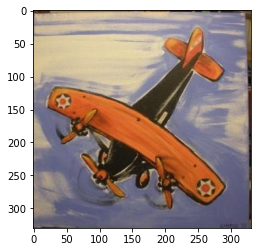

In [44]:
imgplot = plt.imshow(img)

In [45]:
img.shape

(330, 330, 3)

#### Let's check the color properties of the image

In [58]:
#The following are the mean colors reported by Etsy
paintings_with_new_style_tags_and_image_info_df.iloc[0]

listing_id                                                              40722367
user_id                                                                  9264578
shop_id                                                                  5800355
title                                                              US Mail Plane
description                    This is a painting of one of my favorites from...
shop_section_id                                                        6798937.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/40722367/us-mail-...
num_favorers                                                                  55
is_customizable                                                            False
tags                           ['toys', 'plane', 'vintage', 'children', 'nurs...
materials                                            ['acrylic paint on canvas']
shipping_profile_id         

In [46]:
#Let's check if the mean colors actually match those reported by the /images request 
r_mean, g_mean, b_mean = np.mean(img,axis=(0,1))


In [47]:
r_mean

144.10858585858585

In [48]:
g_mean

121.71976124885215

In [49]:
b_mean

113.31157024793389

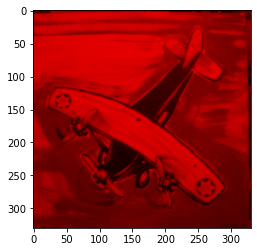

In [50]:
img_red = img.copy()
img_red[:,:,1:]=0
plt.imshow(img_red)

# #Alternatively:
# img_red = np.zeros(img.shape,dtype=int)
# img_red[:,:,0]=img[:,:,0]
# plt.imshow(img_red)

In [51]:
np.mean(img_red,axis=(0,1))

array([144.10858586,   0.        ,   0.        ])

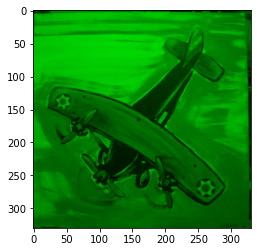

In [52]:
img_green = img.copy()
img_green[:,:,0]=0
img_green[:,:,2]=0
plt.imshow(img_green)

# # #Alternatively:
# img_green = np.zeros(img.shape,dtype=int)
# img_green[:,:,1]=img[:,:,1]
# plt.imshow(img_green)

In [53]:
np.mean(img_green,axis=(0,1))

array([  0.        , 121.71976125,   0.        ])

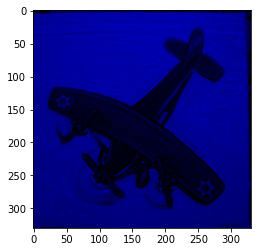

In [54]:
img_blue = img.copy()
img_blue[:,:,:2]=0
plt.imshow(img_blue)

# # #Alternatively:
# img_blue = np.zeros(img.shape,dtype=int)
# img_blue[:,:,2]=img[:,:,2]
# plt.imshow(img_blue)

In [55]:
np.mean(img_blue,axis=(0,1))

array([  0.        ,   0.        , 113.31157025])

In [56]:
img_test = img_red + img_green + img_blue

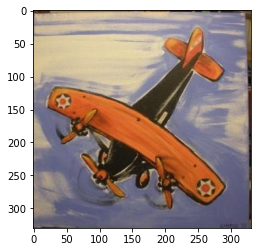

In [57]:
plt.imshow(img_test)

In [59]:
#Note that the average colors don't match those reported... maybe there's some rescaling involved?
r_mean/paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_red']

1.134713274477054

In [60]:
g_mean/paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_green']

1.1817452548432248

In [61]:
b_mean/paintings_with_new_style_tags_and_image_info_df.iloc[0]['image_blue']

1.3175763982317894

In [ ]:
#There doesn't seem to be a clear relation between the image mean colors reported by Etsy and those in the
#images themselves, so I will have to compute the color information myself within the 'image processing'
#part of the code (for version 2.0 of the App)